https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html

Assumptions of LDA
LDA assumes:

1. Each feature (variable or dimension or attribute) in the dataset is a gaussian distribution. In other words, each feature in the dataset is shaped like a bell-shaped curve.
2. Each feature has the same variance, the value of each feature varies around the mean with the same amount on average.

3. Each feature is assumed to be randomly sampled.

4. Lack of multicollinearity in independent features. Increase in correlations between independent features and the power of prediction decreases.

In [1]:
import pandas as pd
import numpy as np
import sklearn.discriminant_analysis as dis_an
import sklearn.model_selection as mdl_sl
from matplotlib import pyplot as plt
import scipy as sc
import sklearn.ensemble as ens
import sklearn.covariance as cov
import sklearn.neighbors as nei
import sklearn.svm as svm
import sklearn.preprocessing as prp
import pylab
from sklearn.pipeline import Pipeline
import sklearn.feature_selection as feat_sel

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [102]:
pd.options.display.float_format = '{:.6f}'.format

In [3]:
data_path = 'data/train.csv'
data = pd.read_csv(data_path)

Tradiotional old way of splitting data

In [4]:
train, test = mdl_sl.train_test_split(data, test_size=0.3)

In [5]:
x_train = train[list(train.columns[:-1])]
x_train_array = np.array(x_train)
y_train = train[['Lead']]
y_train_array = np.array(y_train['Lead'].to_list())

In [6]:
x_test = test[list(test.columns[:-1])]
x_test_array = np.array(x_test)
y_test = test[['Lead']]
y_test_array = np.array(y_test['Lead'].to_list())

In [7]:
model_lda = dis_an.LinearDiscriminantAnalysis().fit(x_train_array, y_train_array)

In [8]:
model_lda.score(x_train_array, y_train_array)

0.8583218707015131

In [9]:
model_lda.score(x_test_array, y_test_array)

0.8685897435897436

### Very Important! Understand Stratified K-fold! https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Stratification seeks to ensure that each fold is representative of all strata of the data. Generally this is done in a supervised way for classification and aims to ensure each class is (approximately) equally represented across each test fold (which are of course combined in a complementary way to form training folds).

The intuition behind this relates to the bias of most classification algorithms. They tend to weight each instance equally which means overrepresented classes get too much weight (e.g. optimizing F-measure, Accuracy or a complementary form of error). Stratification is not so important for an algorithm that weights each class equally (e.g. optimizing Kappa, Informedness or ROC AUC) or according to a cost matrix (e.g. that is giving a value to each class correctly weighted and/or a cost to each way of misclassifying). See, e.g. D. M. W. Powers (2014), What the F-measure doesn't measure: Features, Flaws, Fallacies and Fixes. http://arxiv.org/pdf/1503.06410

One specific issue that is important across even unbiased or balanced algorithms, is that they tend not to be able to learn or test a class that isn't represented at all in a fold, and furthermore even the case where only one of a class is represented in a fold doesn't allow generalization to performed resp. evaluated. However even this consideration isn't universal and for example doesn't apply so much to one-class learning, which tries to determine what is normal for an individual class, and effectively identifies outliers as being a different class, given that cross-validation is about determining statistics not generating a specific classifier.

On the other hand, supervised stratification compromises the technical purity of the evaluation as the labels of the test data shouldn't affect training, but in stratification are used in the selection of the training instances. Unsupervised stratification is also possible based on spreading similar data around looking only at the attributes of the data, not the true class. See, e.g. http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.469.8855 N. A. Diamantidis, D. Karlis, E. A. Giakoumakis (1997), Unsupervised stratification of cross-validation for accuracy estimation.

In [10]:
x = data[list(data.columns[:-1])]
x_array = np.array(x)
x.index = list(x.index)
y = data[['Lead']]
y_array = np.array(y)
y.index = list(y.index)

test data by changing training and test datasets

In [11]:
model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array, y_array, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.8637201269604183

test by changing the solver and fining the optimal one

In [12]:
model = dis_an.LinearDiscriminantAnalysis()

# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']

#n_jobs = Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. 
#-1 means using all processors.

search = mdl_sl.GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

results = search.fit(x_array, y_array)

In [13]:
print(results.best_score_)

print(results.best_params_)

0.8637201269604183
{'solver': 'svd'}


Next, we can explore whether using shrinkage with the model improves performance.

Shrinkage adds a penalty to the model that acts as a type of regularizer, reducing the complexity of the model

In [14]:
model = dis_an.LinearDiscriminantAnalysis()

# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = dict()

grid['shrinkage'] = np.arange(0, 1, 0.01)
grid['solver'] = ['lsqr', 'eigen']


search = mdl_sl.GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

results = search.fit(x_array, y_array)

In [15]:
print(results.best_score_)
print(results.best_params_)

0.8646471247199403
{'shrinkage': 0.0, 'solver': 'lsqr'}


### Plotting

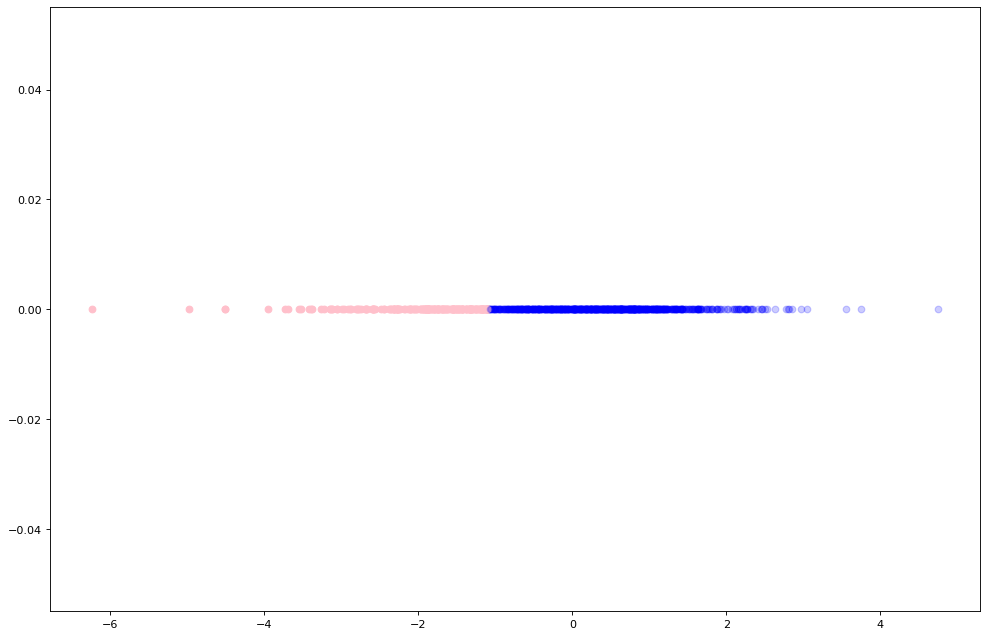

In [16]:
model = dis_an.LinearDiscriminantAnalysis(solver = 'svd')

data_plot = model.fit(x_array, y_array).transform(x_array)

y_predict = model.predict(x_array)

plt.figure(figsize=(15, 10), dpi=80)

for i in range(0, len(data_plot)):
    if y_predict[i] == 'Female':
        plt.scatter(data_plot[i], 0, color = 'pink', alpha=1)
    else:
        plt.scatter(data_plot[i], 0, color = 'blue', alpha=.2)
        
plt.show()

### How to Prepare the data for LDA
Machine learning model performance is greatly dependent upon how well we pre-process data. Let’s see how to prepare our data before we apply LDA:

1. Outlier Treatment: Outliers from the data should be removed, outliers will introduce skewness and in-turn computations of mean and variance will be influenced and finally, that will have an impact on LDA computations.

2. Equal Variance: Standardization of input data, such that it has a mean 0 and a standard deviation of 1.

3. Gaussian distribution: Univariate analysis of each input feature and if they do not exhibit the gaussian distribution transform them to look like Gaussian distribution(log and root for exponential distributions).

In [17]:
x.head()

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0


In [18]:
model = dis_an.LinearDiscriminantAnalysis(solver = 'svd')

model.fit(x_array, y_array)

x_lda = model.transform(x_array)

y_predict = model.predict(x_array)

### Outlier Treatment

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

###### Boxplots

In [177]:
Image(url= "https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png")

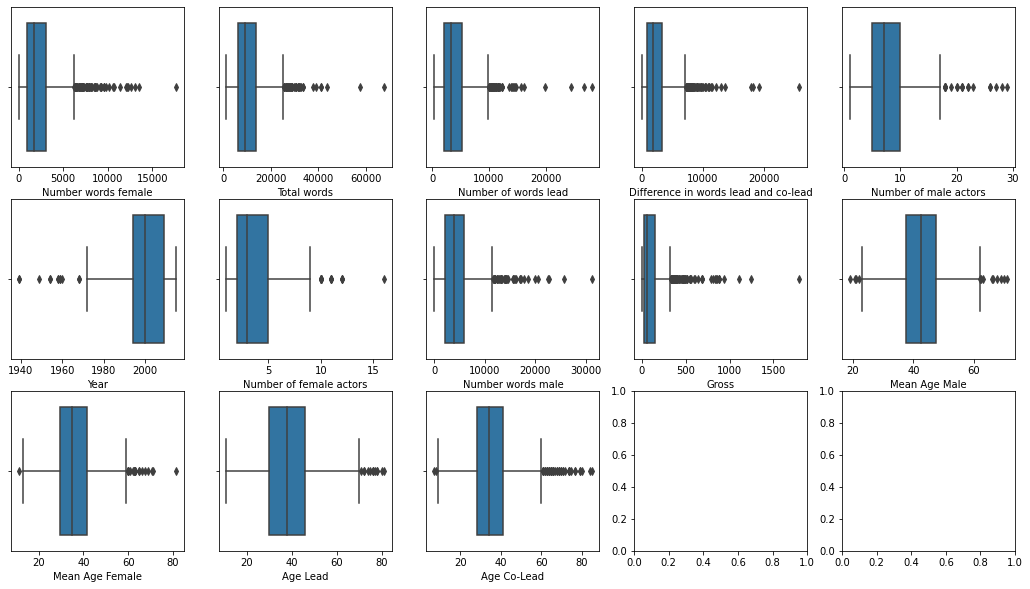

In [19]:
import seaborn as sns

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
i = 0
j = 0

for col in x.columns:
    sns.boxplot(ax=axes[i, j], x=x[col])
    j+=1
    if j > 4:
        i += 1
        j = 0

###### Z-Score

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [20]:
z = np.abs(sc.stats.zscore(x))

In [21]:
threshold = 3
x_1 = x[(z <= threshold).all(axis=1)]

In [22]:
y_new = y.loc[x_1.index]

In [23]:
print(len(x) - len(x_1), "records removed")

115 records removed


Make a function to implement fast Z-score outlier removal

In [24]:
def zscore_outlier_removal(x, threshold, y):
    z = np.abs(sc.stats.zscore(x))
    x_new = x[(z <= threshold).all(axis=1)]
    y_new = y.loc[x_new.index]
    print(len(x) - len(x_new), "records removed")
    return x_new, np.array(x_new), y_new, np.array(y_new)

###### IQR Score

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [25]:
Q1 = x_1.quantile(0.25)
Q3 = x_1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Number words female                     1982.250000
Total words                             6676.500000
Number of words lead                    2911.750000
Difference in words lead and co-lead    2495.750000
Number of male actors                      5.000000
Year                                      13.250000
Number of female actors                    2.000000
Number words male                       3602.000000
Gross                                    115.250000
Mean Age Male                             10.000000
Mean Age Female                           11.666667
Age Lead                                  15.000000
Age Co-Lead                               13.000000
dtype: float64


In [26]:
x_2 = x_1[~((x_1 < (Q1 - 1.5 * IQR)) | (x_1 > (Q3 + 1.5 * IQR))).any(axis=1)]
x_2.shape

(695, 13)

In [27]:
print(len(x_1) - len(x_2), "records removed")

229 records removed


In [28]:
def iqrscore_outlier_removal(x, y):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    x_new = x[~((x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR))).any(axis=1)]
    y_new = y.loc[x_new.index]
    print(len(x) - len(x_new), "records removed")
    return x_new, np.array(x_new), y_new, np.array(y_new)

https://medium.com/mlearning-ai/how-to-find-and-remove-outliers-from-a-regression-in-python-449bc9e13101

In Python’s premier machine learning library, sklearn, there are four functions that can be used to identify outliers, being IsolationForest, EllepticEnvelope, LocalOutlierFactor, and OneClassSVM.

https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

##### IsolationForest

In [29]:
def isolationforest_outlier_removal(x_array, x, y):
    iso = ens.IsolationForest()
    y_predict = iso.fit_predict(x_array)
    
    x_new = x[y_predict == 1]
    y_new = y[y_predict == 1]

    return x_new, np.array(x_new), y_new, np.array(y_new)

##### EllepticEnvelope

In [30]:
def ellepticenvelope_outlier_removal(x_array, x, y):
    ee = cov.EllipticEnvelope()
    y_predict = ee.fit_predict(x_array)

    x_new = x[y_predict == 1]
    y_new = y[y_predict == 1]

    return x_new, np.array(x_new), y_new, np.array(y_new)

##### LocalOutlierFactor

In [31]:
def localoutlierfactor_outlier_removal(x_array, x, y):
    lof = nei.LocalOutlierFactor()
    y_predict = lof.fit_predict(x_array)

    x_new = x[y_predict == 1]
    y_new = y[y_predict == 1]

    return x_new, np.array(x_new), y_new, np.array(y_new)

##### OneClassSVM

In [32]:
def oneclasssvm_outlier_removal(x_array, x, y):
    ocs = svm.OneClassSVM(nu=0.05)
    y_predict = ocs.fit_predict(x_array)

    x_new = x[y_predict == 1]
    y_new = y[y_predict == 1]

    return x_new, np.array(x_new), y_new, np.array(y_new)

### Standardization of input data

https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

#### Data Normalization

In [33]:
def normalize(x):
    
    normalized_x = pd.DataFrame(prp.normalize(x), columns = x.columns)
    
    normalized_x_array = np.array(normalized_x)
    
    return normalized_x, normalized_x_array

#### Data Standardization

In [34]:
def standarize(x):
    
    standarized_x = pd.DataFrame(prp.scale(x), columns = x.columns)
    
    standarized_x_array = np.array(standarized_x)
    
    return standarized_x, standarized_x_array

### Warning Risk of data leak
Do not use scale unless you know what you are doing. A common mistake is to apply it to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set. In general, we recommend using StandardScaler within a Pipeline in order to prevent most risks of data leaking: pipe = make_pipeline(StandardScaler(), LogisticRegression()).

### Gaussian distribution

Univariate analysis of each input feature and if they do not exhibit the gaussian distribution transform them to look like Gaussian distribution(log and root for exponential distributions).

https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/

<AxesSubplot:xlabel='Number words female', ylabel='Count'>

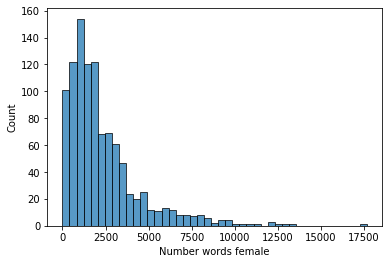

In [35]:
sns.histplot(x['Number words female'])

<AxesSubplot:xlabel='Number words female', ylabel='Density'>

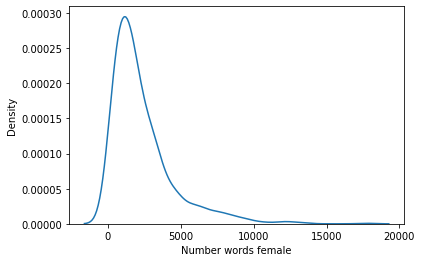

In [36]:
sns.kdeplot(x['Number words female'])

((array([-3.20860341, -2.94423376, -2.79675878, ...,  2.79675878,
          2.94423376,  3.20860341]),
  array([    0,     0,     0, ..., 13054, 13530, 17658], dtype=int64)),
 (1939.2609088456506, 2334.256015399423, 0.8969804083195894))

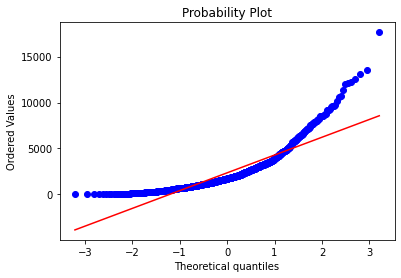

In [37]:
sc.stats.probplot(x['Number words female'],plot=pylab)

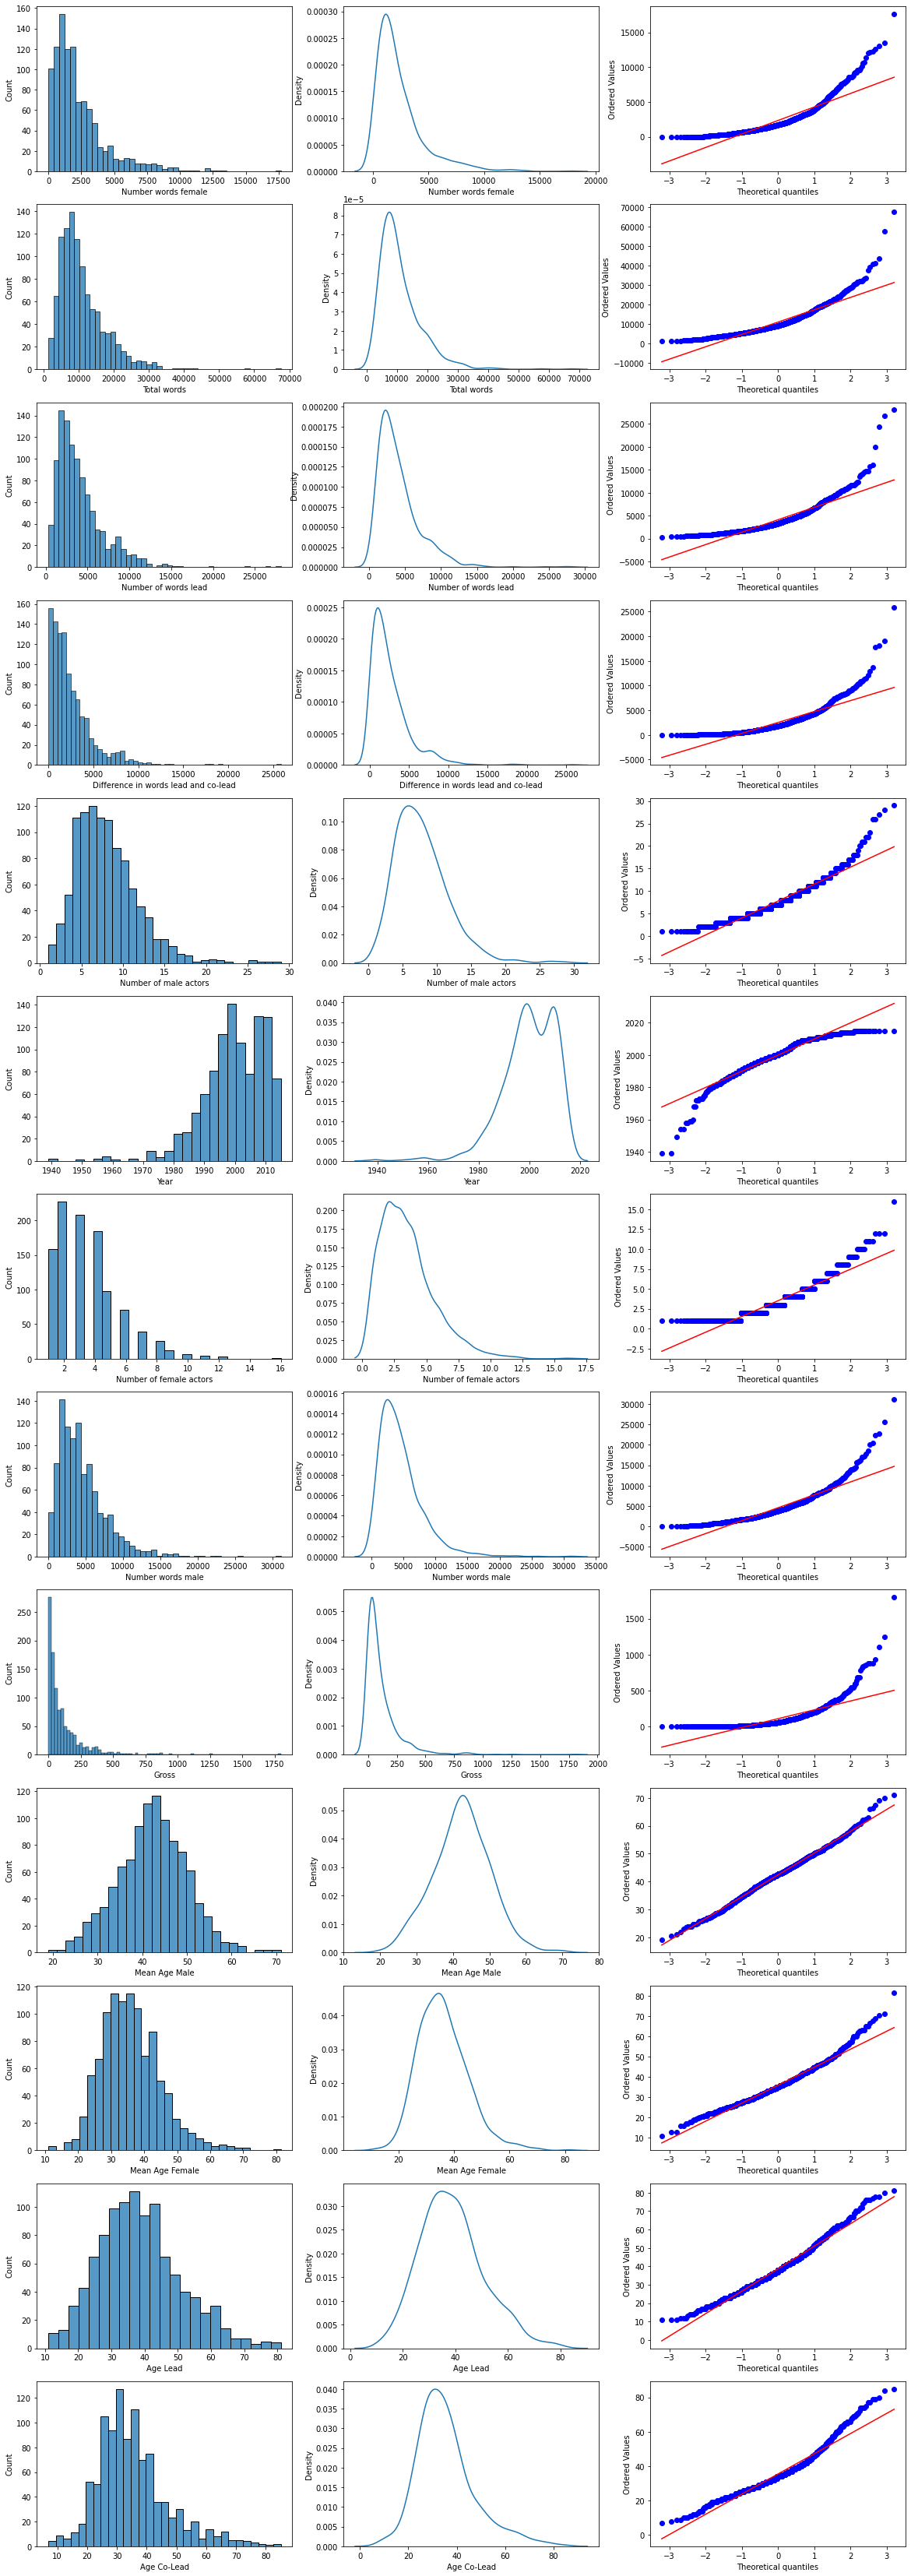

In [38]:
fig, axes = plt.subplots(13, 3, figsize=(20, 60))
i = 0

for col in x.columns:
    
    sns.histplot(ax = axes[i, 0], x=x[col])
    sns.kdeplot(ax = axes[i, 1], x=x[col])
    
    sc.stats.probplot(x= x[col],plot=axes[i, 2])
    axes[i, 2].set_title("")
    
    i += 1

In [39]:
x.columns

Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead'],
      dtype='object')

In [40]:
np.zeros(13)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
#function to return plots for the feature
def normality(data,feature):
    fig, axes = plt.subplots(1, 3, figsize=(16, 2))
    sns.histplot(ax = axes[0], x=data[feature])
    sns.kdeplot(ax = axes[1], x=data[feature])
    sc.stats.probplot(x = data[feature], plot=axes[2])

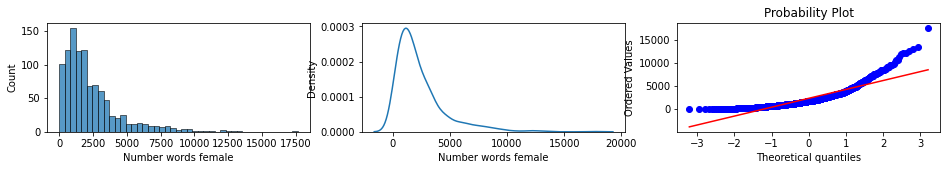

In [42]:
normality(x,'Number words female')

Logarithmic Transformation – This will convert the Price value to its log value i.e log(Price)
Reciprocal Transformation – This will inverse values of Price i.e1/Price
Square Root Transformation – This transformation will take the square root of the Price column i.e sqrt(Price).
Exponential Transformation: The exponential value of the Price variable will be taken.

In [43]:
def compare_gaussian_transformation(data, feature):
    data_log = pd.DataFrame(columns=[feature])
    data_inverse = pd.DataFrame(columns=[feature])
    data_square_root = pd.DataFrame(columns=[feature])
    data_exponential = pd.DataFrame(columns=[feature])
    data_box_cox = pd.DataFrame(columns=[feature])
    
    data_log[feature] = np.log(data[feature])
    data_inverse[feature] = 1/data[feature]
    data_square_root[feature] = np.sqrt(data[feature])
    data_exponential[feature] = data[feature]**(1/1.2)
    
    normality(data_log,feature)
    normality(data_inverse,feature)
    normality(data_square_root,feature)
    normality(data_exponential,feature)
    
    try:
        data_box_cox[feature]=sc.stats.boxcox(data[feature])[0]
        normality(data_box_cox,feature)
    except:
        print('Box Cox negative!')

In [44]:
x_gaussian_fixed = x.copy()

Box Cox negative!


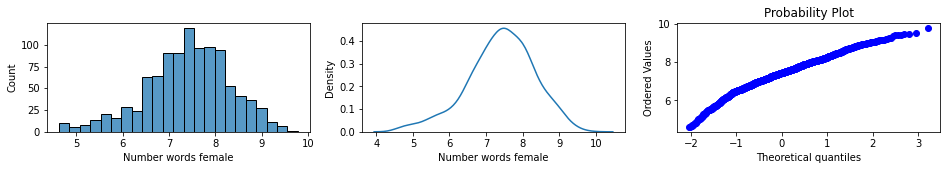

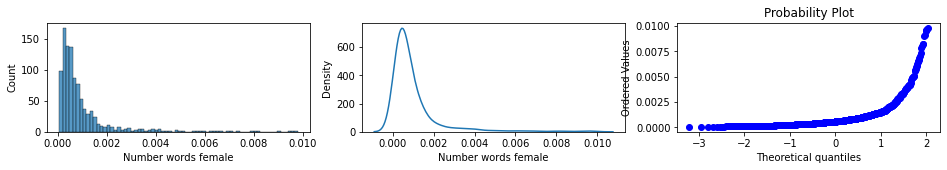

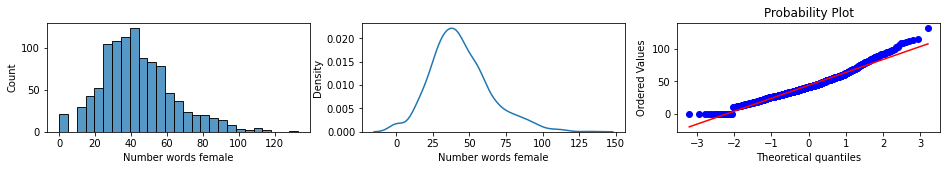

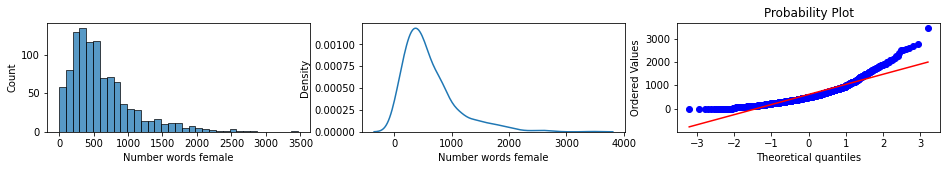

In [45]:
compare_gaussian_transformation(x, 'Number words female')

In [46]:
x_gaussian_fixed['Number words female'] = np.log(x_gaussian_fixed['Number words female'])

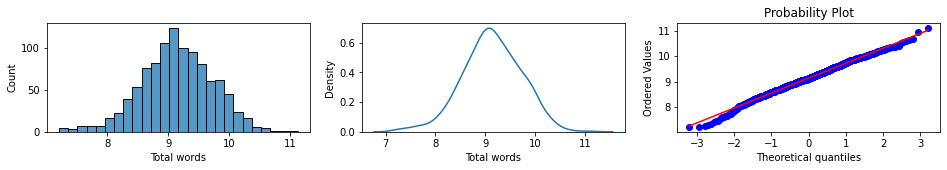

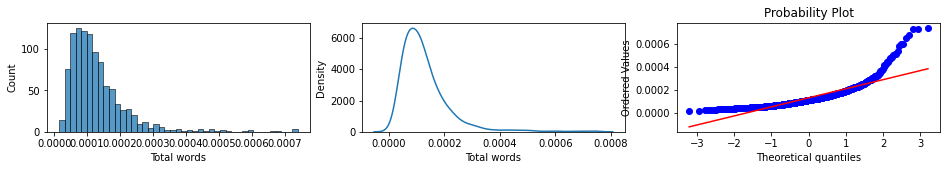

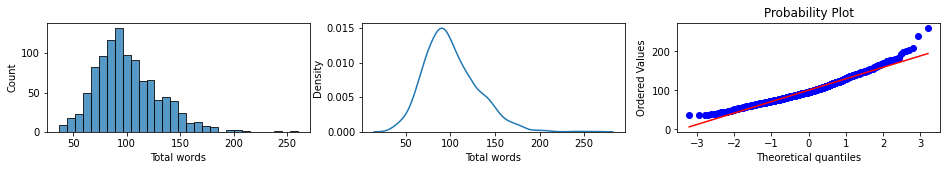

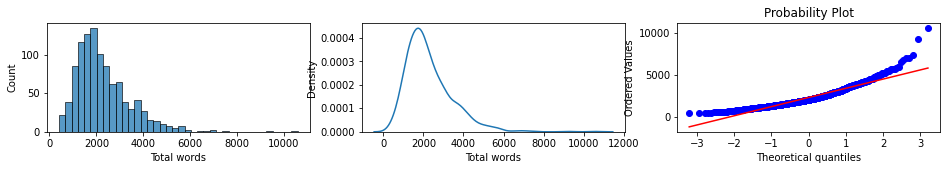

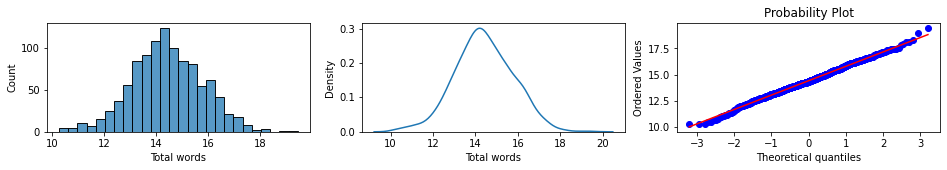

In [47]:
compare_gaussian_transformation(x, 'Total words')

In [48]:
x_gaussian_fixed['Total words'] = sc.stats.boxcox(x_gaussian_fixed['Total words'])[0]

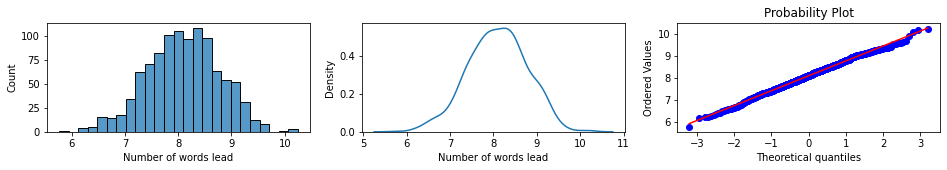

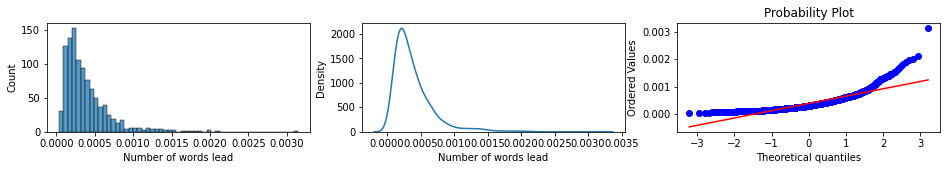

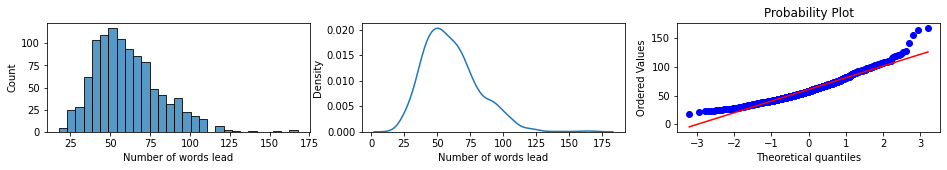

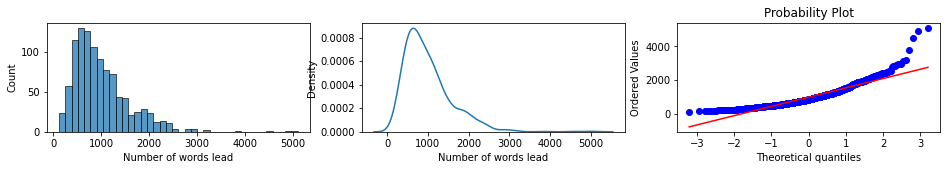

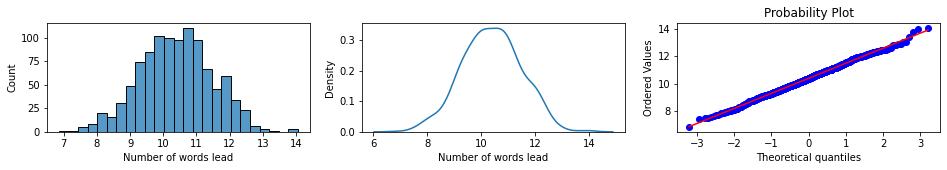

In [49]:
compare_gaussian_transformation(x, 'Number of words lead')

In [50]:
x_gaussian_fixed['Number of words lead'] = np.log(x_gaussian_fixed['Number of words lead'])

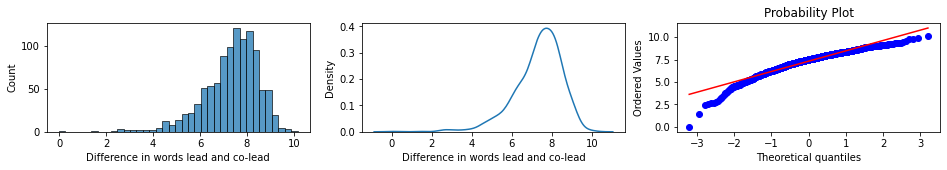

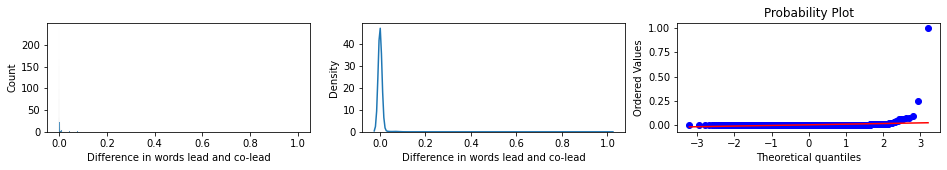

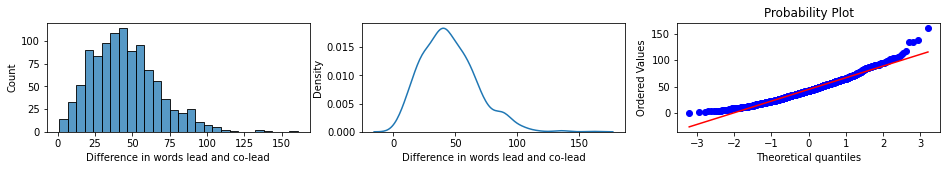

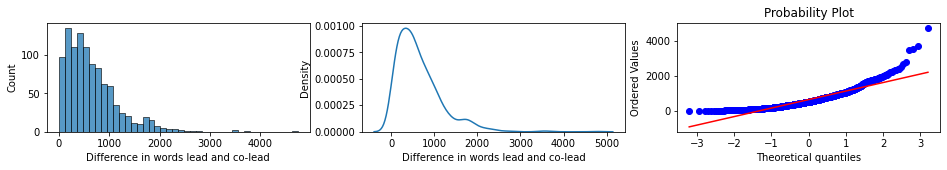

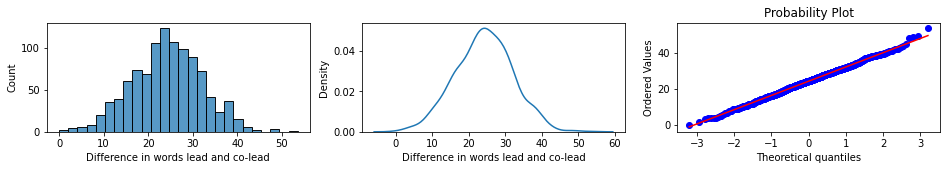

In [51]:
compare_gaussian_transformation(x, 'Difference in words lead and co-lead')

In [52]:
x_gaussian_fixed['Difference in words lead and co-lead'] = sc.stats.boxcox(x_gaussian_fixed['Difference in words lead and co-lead'])[0]

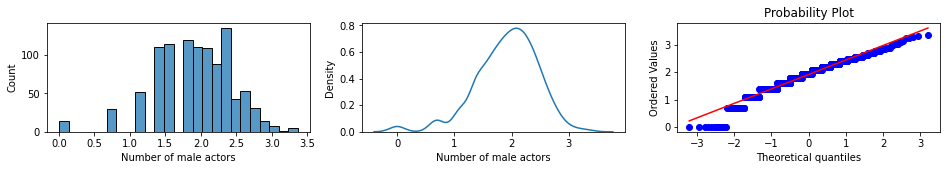

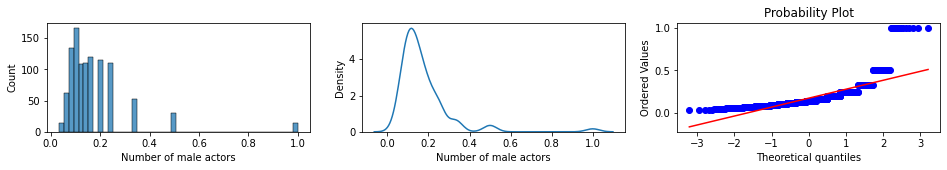

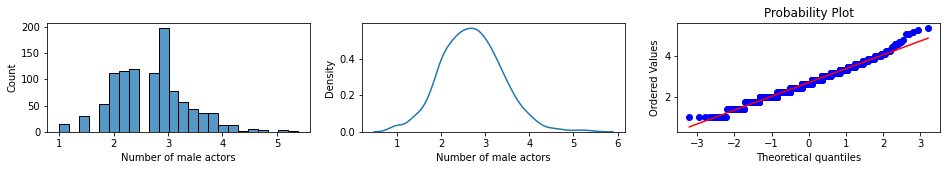

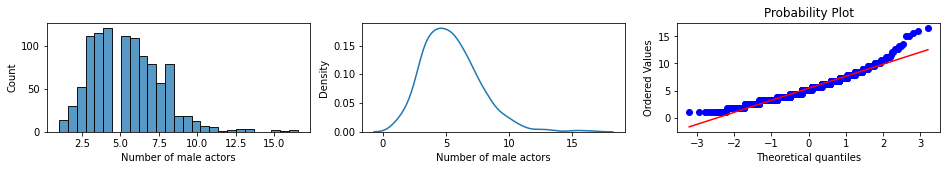

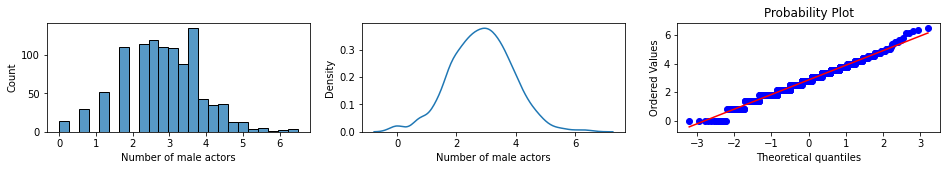

In [53]:
compare_gaussian_transformation(x, 'Number of male actors')

In [54]:
x_gaussian_fixed['Number of male actors'] = sc.stats.boxcox(x_gaussian_fixed['Number of male actors'])[0]

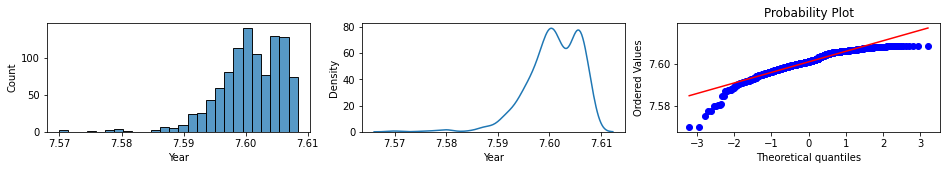

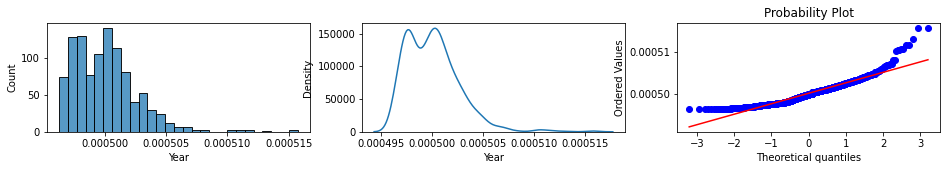

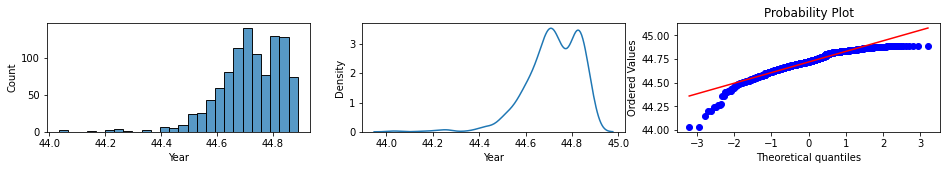

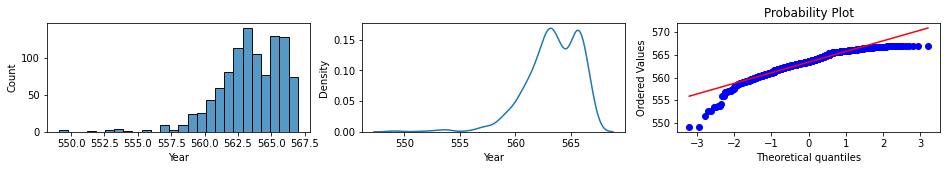

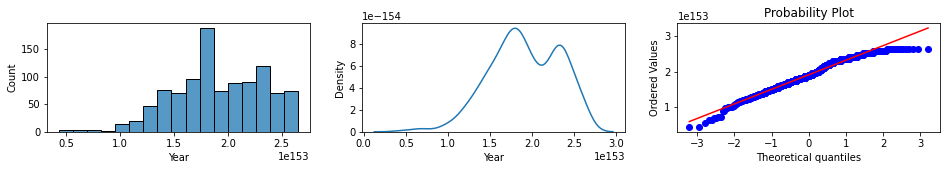

In [55]:
compare_gaussian_transformation(x, 'Year')

In [56]:
x_gaussian_fixed['Year'] = sc.stats.boxcox(x_gaussian_fixed['Year'])[0]

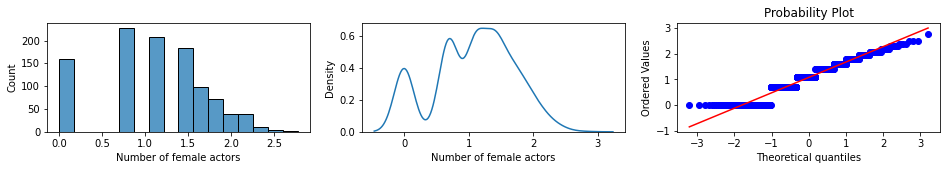

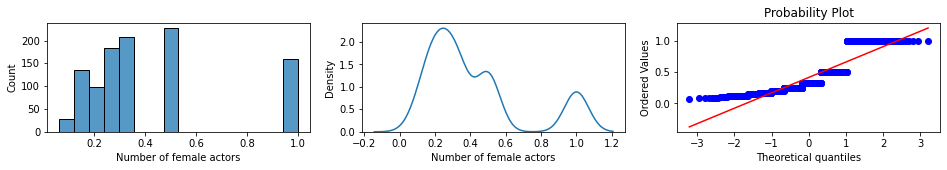

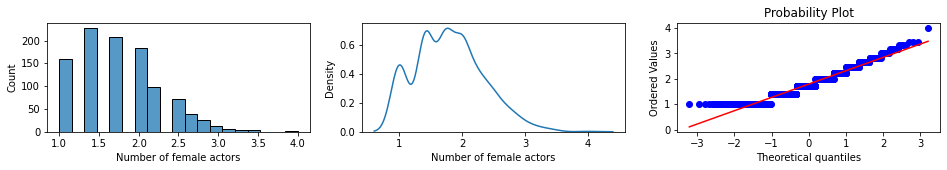

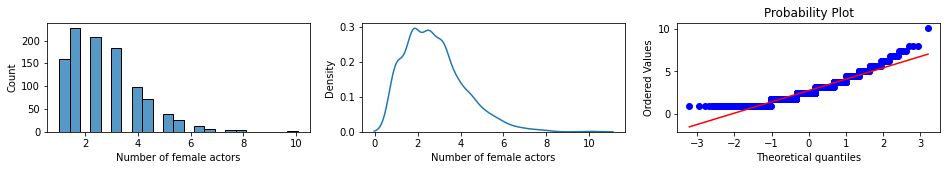

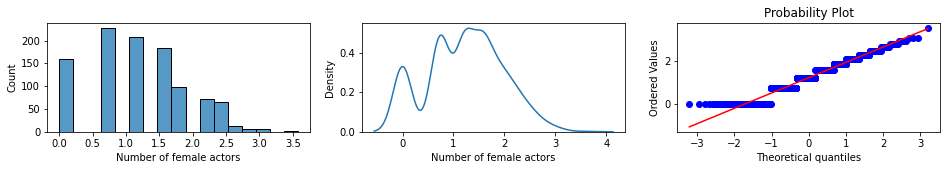

In [57]:
compare_gaussian_transformation(x, 'Number of female actors')

In [58]:
x_gaussian_fixed['Number of female actors'] = x_gaussian_fixed['Number of female actors']**(1/1.2)

Box Cox negative!


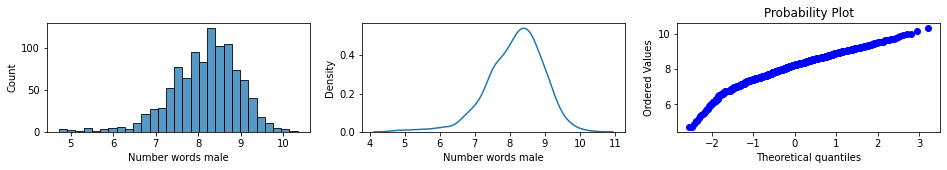

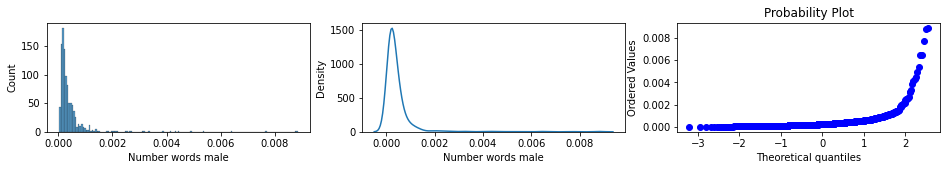

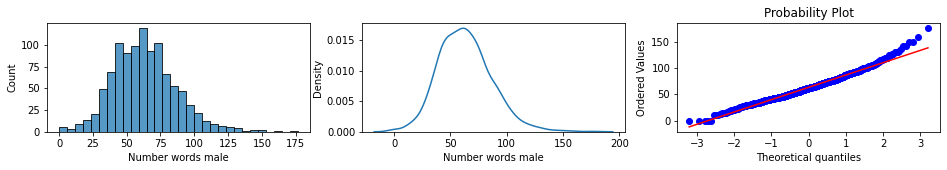

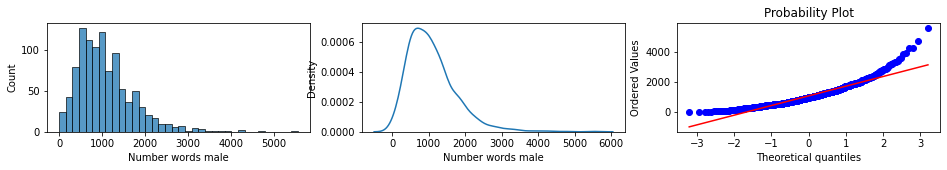

In [59]:
compare_gaussian_transformation(x, 'Number words male')

In [60]:
x_gaussian_fixed['Number words male'] = np.log(x_gaussian_fixed['Number words male'])

Box Cox negative!


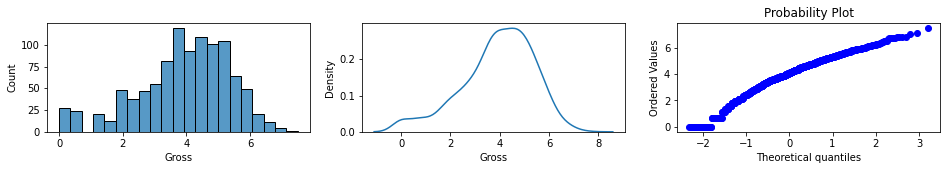

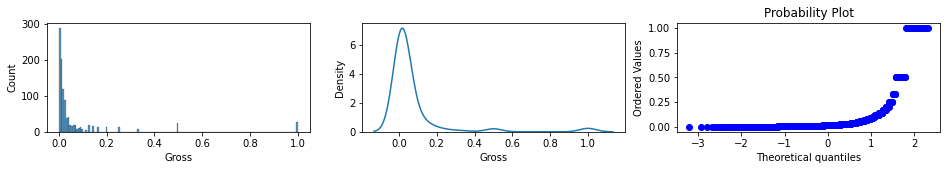

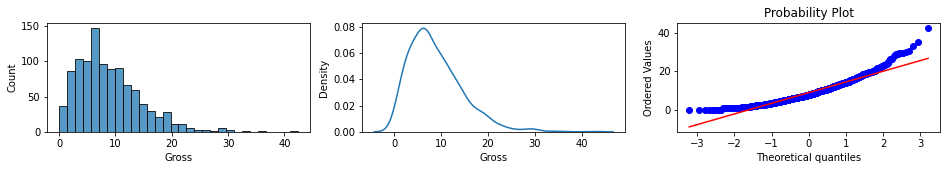

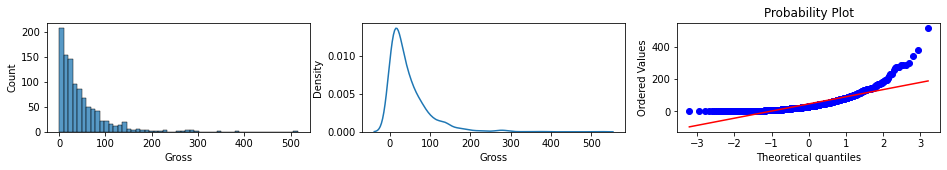

In [61]:
compare_gaussian_transformation(x, 'Gross')

In [62]:
x_gaussian_fixed['Gross'] = np.log(x_gaussian_fixed['Gross'])

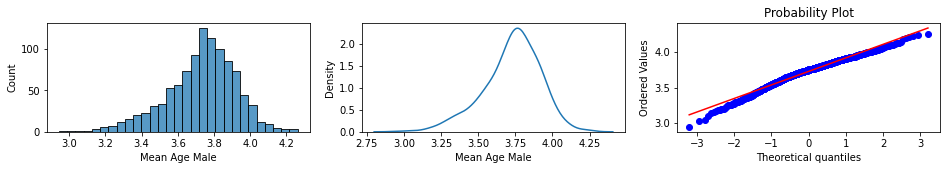

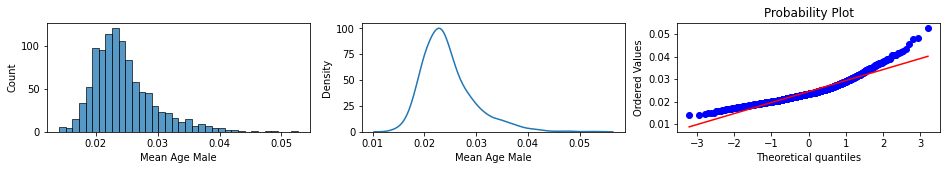

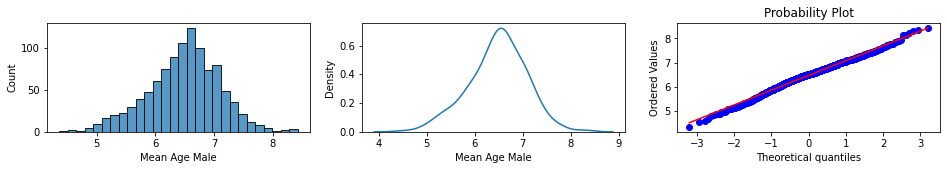

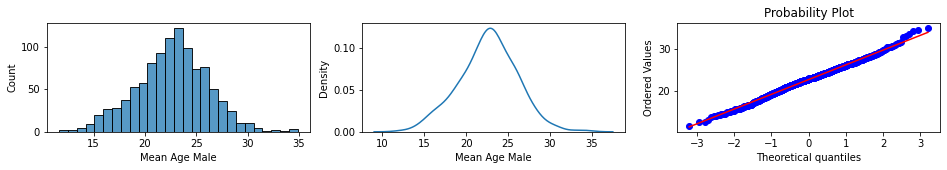

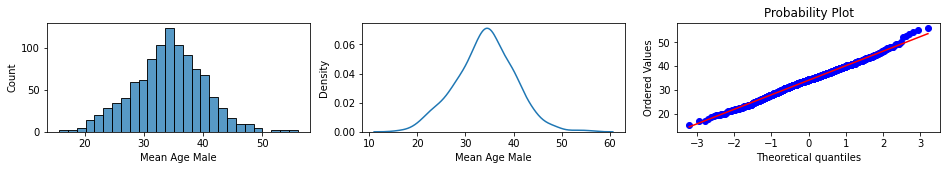

In [63]:
compare_gaussian_transformation(x, 'Mean Age Male')

In [64]:
x_gaussian_fixed['Mean Age Male'] = sc.stats.boxcox(x_gaussian_fixed['Mean Age Male'])[0]

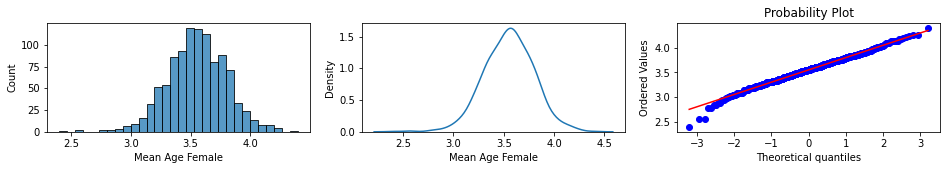

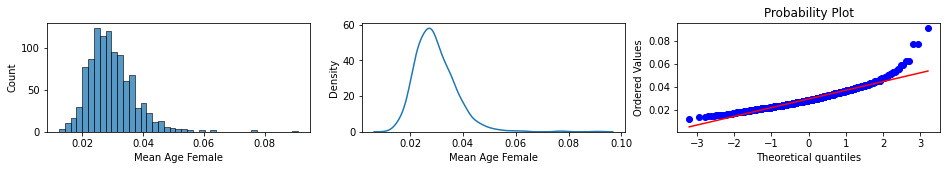

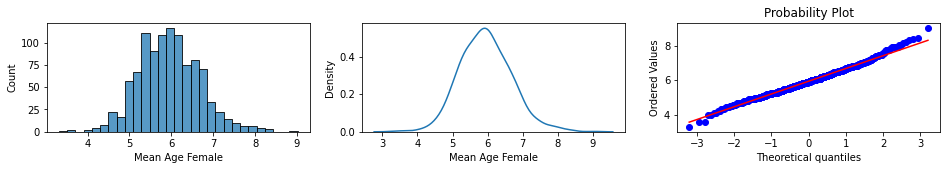

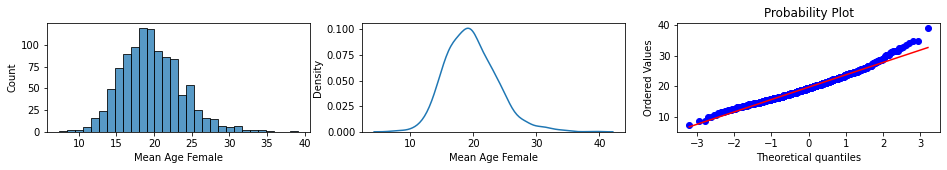

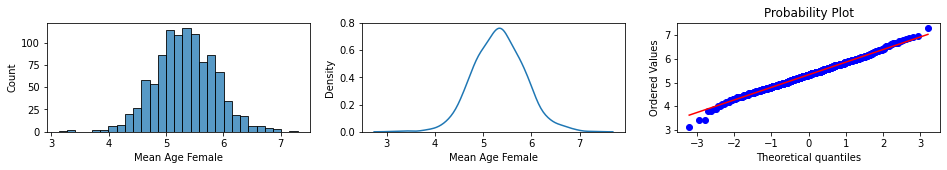

In [65]:
compare_gaussian_transformation(x, 'Mean Age Female')

In [66]:
x_gaussian_fixed['Mean Age Female'] = sc.stats.boxcox(x_gaussian_fixed['Mean Age Female'])[0]

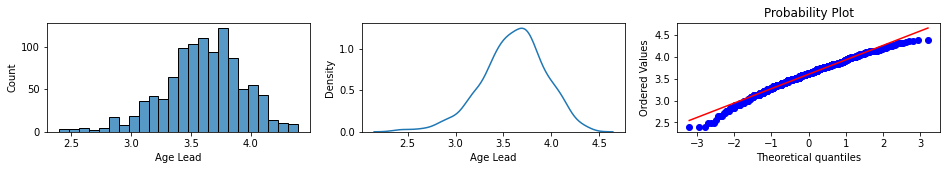

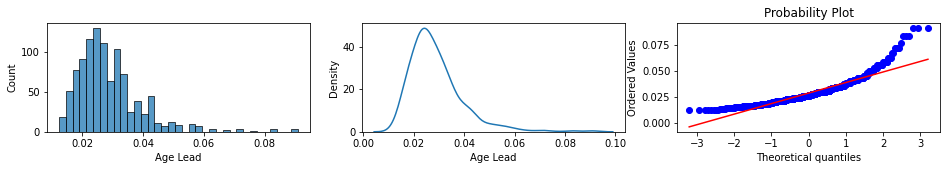

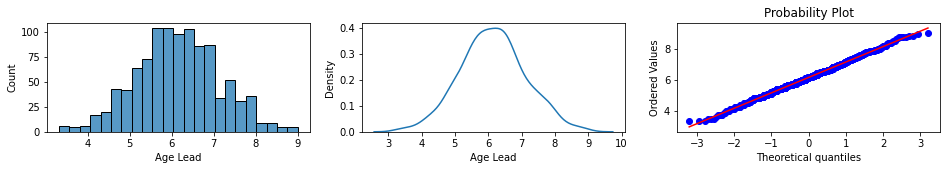

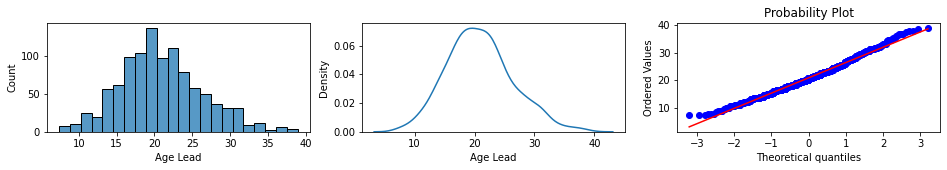

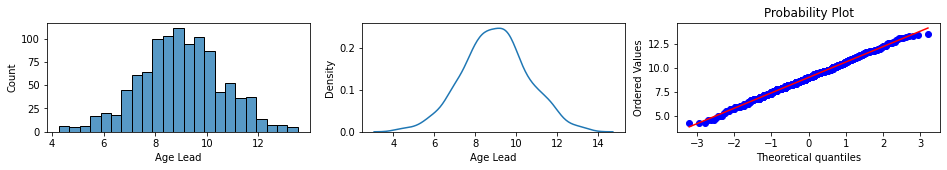

In [67]:
compare_gaussian_transformation(x, 'Age Lead')

In [68]:
x_gaussian_fixed['Age Lead'] = sc.stats.boxcox(x_gaussian_fixed['Age Lead'])[0]

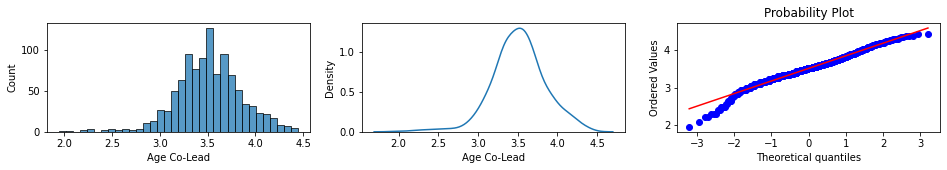

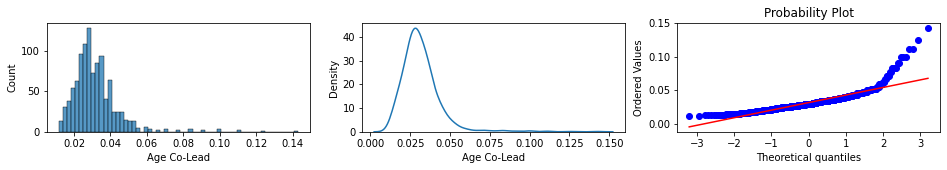

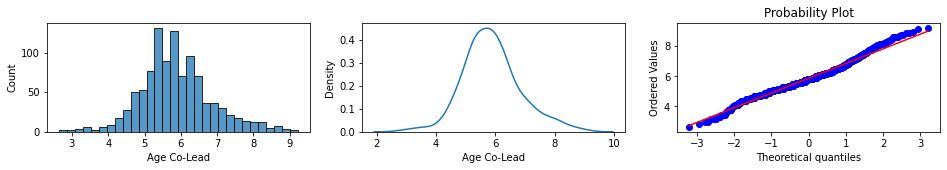

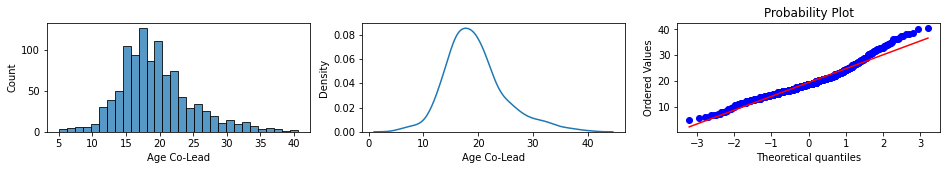

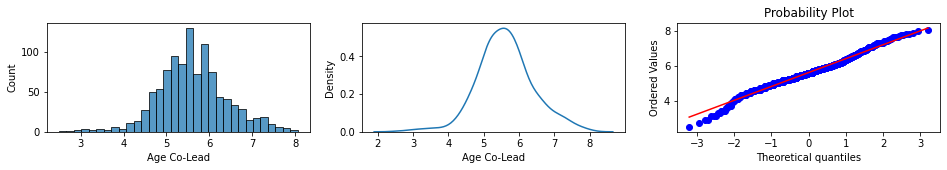

In [69]:
compare_gaussian_transformation(x, 'Age Co-Lead')

In [70]:
x_gaussian_fixed['Age Co-Lead'] = np.sqrt(x_gaussian_fixed['Age Co-Lead'])

In [71]:
x_gaussian_fixed

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead
0,7.321189,13.514413,7.719130,14.171424,0.785883,1.659258e+153,3.823622,7.875119,4.955827,41.254859,5.736766,10.035681,8.062258
1,7.329094,14.239132,7.610853,21.450474,3.328306,1.910422e+153,3.174802,8.563313,3.610918,31.686011,4.951763,11.363488,5.830952
2,5.043425,12.573756,6.848005,18.653580,2.803775,8.752783e+152,1.000000,8.032360,5.929589,34.313647,5.441456,10.035681,6.082763
3,6.978214,14.508429,8.143227,27.217371,3.989099,1.955753e+153,1.781797,8.583355,2.944439,28.628218,4.333400,8.355486,4.795832
4,7.183112,13.933010,8.251925,28.777688,3.076644,1.406898e+153,3.174802,7.838343,3.688879,36.444235,5.873560,8.772079,6.244998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,5.713733,11.403233,7.195937,21.151064,2.170922,9.859865e+152,1.781797,6.634633,5.159055,34.856839,5.066120,10.035681,4.898979
1035,6.448889,14.137835,7.576610,11.476081,2.504444,1.546098e+153,1.781797,8.669056,5.147494,30.154384,4.547672,6.431593,5.830952
1036,7.189922,11.686680,6.776507,14.351479,0.785883,1.866120e+153,2.498050,6.304449,3.970292,22.507174,4.832176,7.611252,5.000000
1037,6.135565,12.477490,6.652863,7.047970,3.076644,1.698749e+153,2.498050,7.921898,3.465736,34.590861,5.527727,7.765692,5.656854


In [72]:
def transform_to_gaussian(x):
    x_new = x.copy()
    x_new['Number words female'] = np.log(x['Number words female'])
    x_new['Total words'] = sc.stats.boxcox(x['Total words'])[0]
    x_new['Number of words lead'] = np.log(x['Number of words lead'])
    x_new['Difference in words lead and co-lead'] = sc.stats.boxcox(x['Difference in words lead and co-lead'])[0]
    x_new['Number of male actors'] = sc.stats.boxcox(x['Number of male actors'])[0]
    x_new['Year'] = sc.stats.boxcox(x['Year'])[0]
    x_new['Number of female actors'] = x['Number of female actors']**(1/1.2)
    x_new['Number words male'] = np.log(x['Number words male'])
    x_new['Gross'] = np.log(x['Gross'])
    x_new['Mean Age Male'] = sc.stats.boxcox(x['Mean Age Male'])[0]
    x_new['Mean Age Female'] = sc.stats.boxcox(x['Mean Age Female'])[0]
    x_new['Age Lead'] = sc.stats.boxcox(x['Age Lead'])[0]
    x_new['Age Co-Lead'] = np.sqrt(x['Age Co-Lead'])
    
    return x_new, np.array(x_new)

#### Outlier Treatment

1. zscore_outlier_removal(x, threshold, y): x_new, np.array(x_new), y_new, np.array(y_new)
2. iqrscore_outlier_removal(x, y): x_new, np.array(x_new), y_new, np.array(y_new)

3. isolationforest_outlier_removal(x_array, x, y): x_new, np.array(x_new), y_new, np.array(y_new)
4. ellepticenvelope_outlier_removal(x_array, x, y): x_new, np.array(x_new), y_new, np.array(y_new)
5. localoutlierfactor_outlier_removal(x_array, x, y): x_new, np.array(x_new), y_new, np.array(y_new)
6. oneclasssvm_outlier_removal(x_array, x, y): x_new, np.array(x_new), y_new, np.array(y_new)

#### Standardization of input data

1. normalize(x): normalized_x, normalized_x_array
2. standarize(x): standarized_x, standarized_x_array

#### Gaussian distribution

1. transform_to_gaussian(x): x, np.array(x)

## Initial Score

In [73]:
model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array, y_array, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.8637201269604183

## Remove outliers (Traditional)
First we use iqr and then the z score

In [74]:
x_new, x_array_new, y_new, y_array_new = zscore_outlier_removal(x, 3, y)

115 records removed


In [75]:
model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.8801975222066383

In [76]:
x_new, x_array_new, y_new, y_array_new = iqrscore_outlier_removal(x, y)

300 records removed


In [77]:
model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.8764679748241392

In [78]:
x_new, x_array_new, y_new, y_array_new = iqrscore_outlier_removal(x, y)
x_new, x_array_new, y_new, y_array_new = zscore_outlier_removal(x_new, 3, y_new)


model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

300 records removed
39 records removed


0.880857142857143

## Remove outliers (Automatic)

oneclasssvm is the best!

In [79]:
# x_new, x_array_new, y_new, y_array_new = isolationforest_outlier_removal(x_array, x, y)
# x_new, x_array_new, y_new, y_array_new = ellepticenvelope_outlier_removal(x_array, x, y)
# x_new, x_array_new, y_new, y_array_new = localoutlierfactor_outlier_removal(x_array, x, y)
x_new, x_array_new, y_new, y_array_new = oneclasssvm_outlier_removal(x_array, x, y)

In [80]:
model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.8828282828282826

### Combine the outliers methods together

We end up that first we have to use oneclasssvm and then iqr and zscore

In [81]:
x_new, x_array_new, y_new, y_array_new = oneclasssvm_outlier_removal(x_array, x, y)
x_new, x_array_new, y_new, y_array_new = iqrscore_outlier_removal(x_new, y_new)
x_new, x_array_new, y_new, y_array_new = zscore_outlier_removal(x_new, 3, y_new)

288 records removed
32 records removed


In [82]:
model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.8843283582089551

## We need to make the distributions Gaussians so we alter the function we made above to fit our needs.

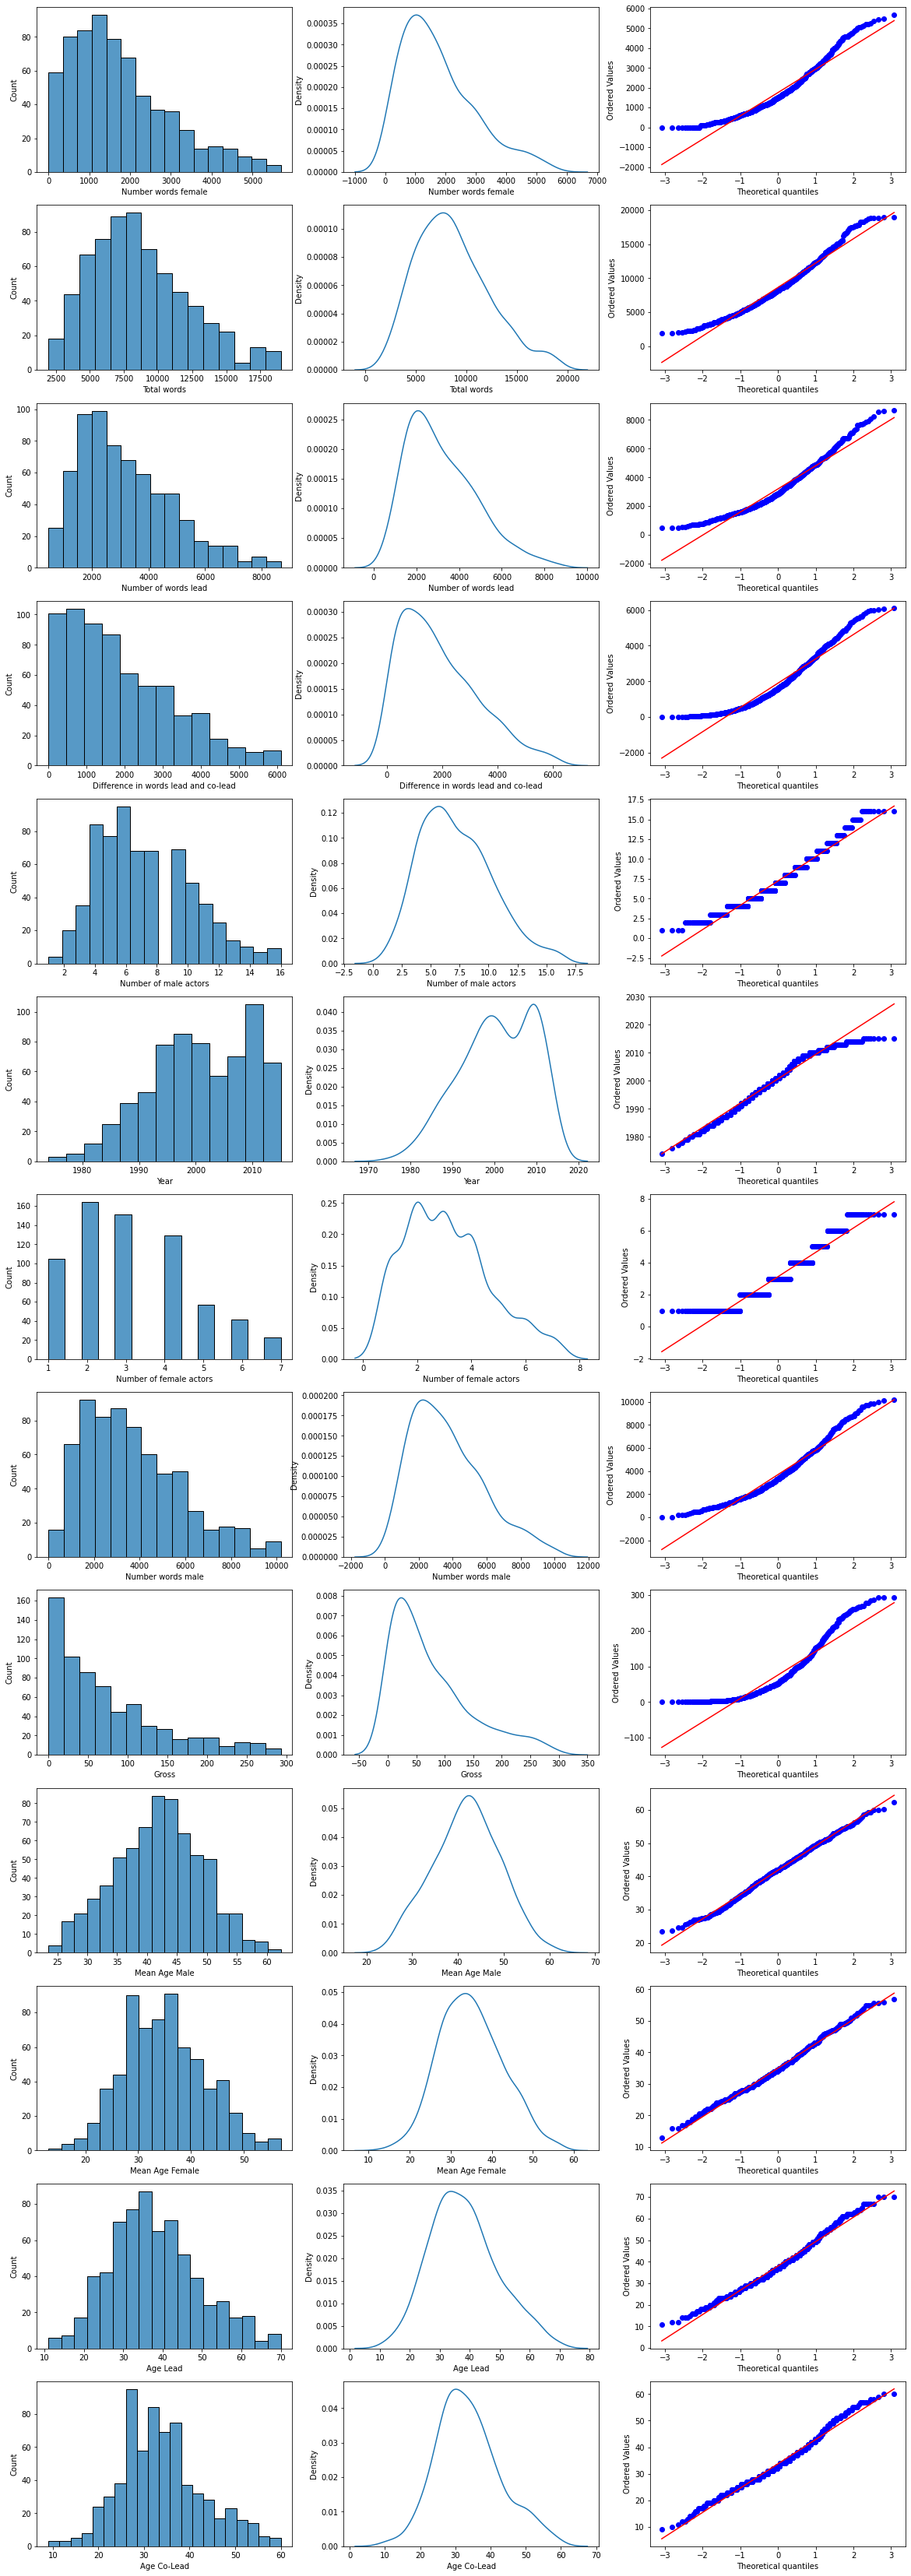

In [83]:
fig, axes = plt.subplots(13, 3, figsize=(20, 60))
i = 0

for col in x_new.columns:
    
    sns.histplot(ax = axes[i, 0], x=x_new[col])
    sns.kdeplot(ax = axes[i, 1], x=x_new[col])
    
    sc.stats.probplot(x= x_new[col],plot=axes[i, 2])
    axes[i, 2].set_title("")
    
    i += 1

In [84]:
def transform_to_gaussian(x):
    x_temp = x.copy()
    for col in x.columns:
        x_temp[col] = sc.stats.boxcox(x[col])[0]
    return x_temp, np.array(x_temp)

We need our data not to have 0 so we add a constant (+1) to 'Number words female', 'Number words male' and 'Gross'

In [85]:
x_new.describe()

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead
count,670.00000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1755.71194,8651.285075,3197.052239,1900.970149,7.220896,2000.707463,3.125373,3698.520896,75.656716,41.861031,35.023333,38.055224,33.765672
std,1216.43145,3618.661790,1647.371410,1404.970206,3.114004,8.805375,1.578759,2147.318856,70.056811,7.313206,7.715321,11.319451,9.199679
min,0.00000,1954.000000,472.000000,1.000000,1.000000,1974.000000,1.000000,0.000000,0.000000,23.500000,13.000000,11.000000,9.000000
25%,829.25000,5910.000000,1909.250000,756.750000,5.000000,1995.000000,2.000000,2009.250000,20.000000,37.000000,29.083333,30.000000,28.000000
50%,1496.00000,8224.500000,2867.500000,1588.000000,7.000000,2001.000000,3.000000,3307.000000,52.500000,42.000000,34.366667,37.000000,33.000000
75%,2464.25000,10908.500000,4229.250000,2827.500000,9.000000,2009.000000,4.000000,5050.500000,109.000000,46.812500,40.000000,45.000000,39.000000
max,5690.00000,18994.000000,8665.000000,6101.000000,16.000000,2015.000000,7.000000,10182.000000,293.000000,62.333333,57.000000,70.000000,60.000000


In [86]:
x_dirty = x_new.copy()
x_dirty['Number words female'] += 1
x_dirty['Number words male'] += 1
x_dirty['Gross'] += 1
x_new = x_dirty

The new dataset looks like this

In [87]:
x_new.describe()

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead
count,670.00000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1756.71194,8651.285075,3197.052239,1900.970149,7.220896,2000.707463,3.125373,3699.520896,76.656716,41.861031,35.023333,38.055224,33.765672
std,1216.43145,3618.661790,1647.371410,1404.970206,3.114004,8.805375,1.578759,2147.318856,70.056811,7.313206,7.715321,11.319451,9.199679
min,1.00000,1954.000000,472.000000,1.000000,1.000000,1974.000000,1.000000,1.000000,1.000000,23.500000,13.000000,11.000000,9.000000
25%,830.25000,5910.000000,1909.250000,756.750000,5.000000,1995.000000,2.000000,2010.250000,21.000000,37.000000,29.083333,30.000000,28.000000
50%,1497.00000,8224.500000,2867.500000,1588.000000,7.000000,2001.000000,3.000000,3308.000000,53.500000,42.000000,34.366667,37.000000,33.000000
75%,2465.25000,10908.500000,4229.250000,2827.500000,9.000000,2009.000000,4.000000,5051.500000,110.000000,46.812500,40.000000,45.000000,39.000000
max,5691.00000,18994.000000,8665.000000,6101.000000,16.000000,2015.000000,7.000000,10183.000000,294.000000,62.333333,57.000000,70.000000,60.000000


In [88]:
x_new, x_array_new = transform_to_gaussian(x_new)

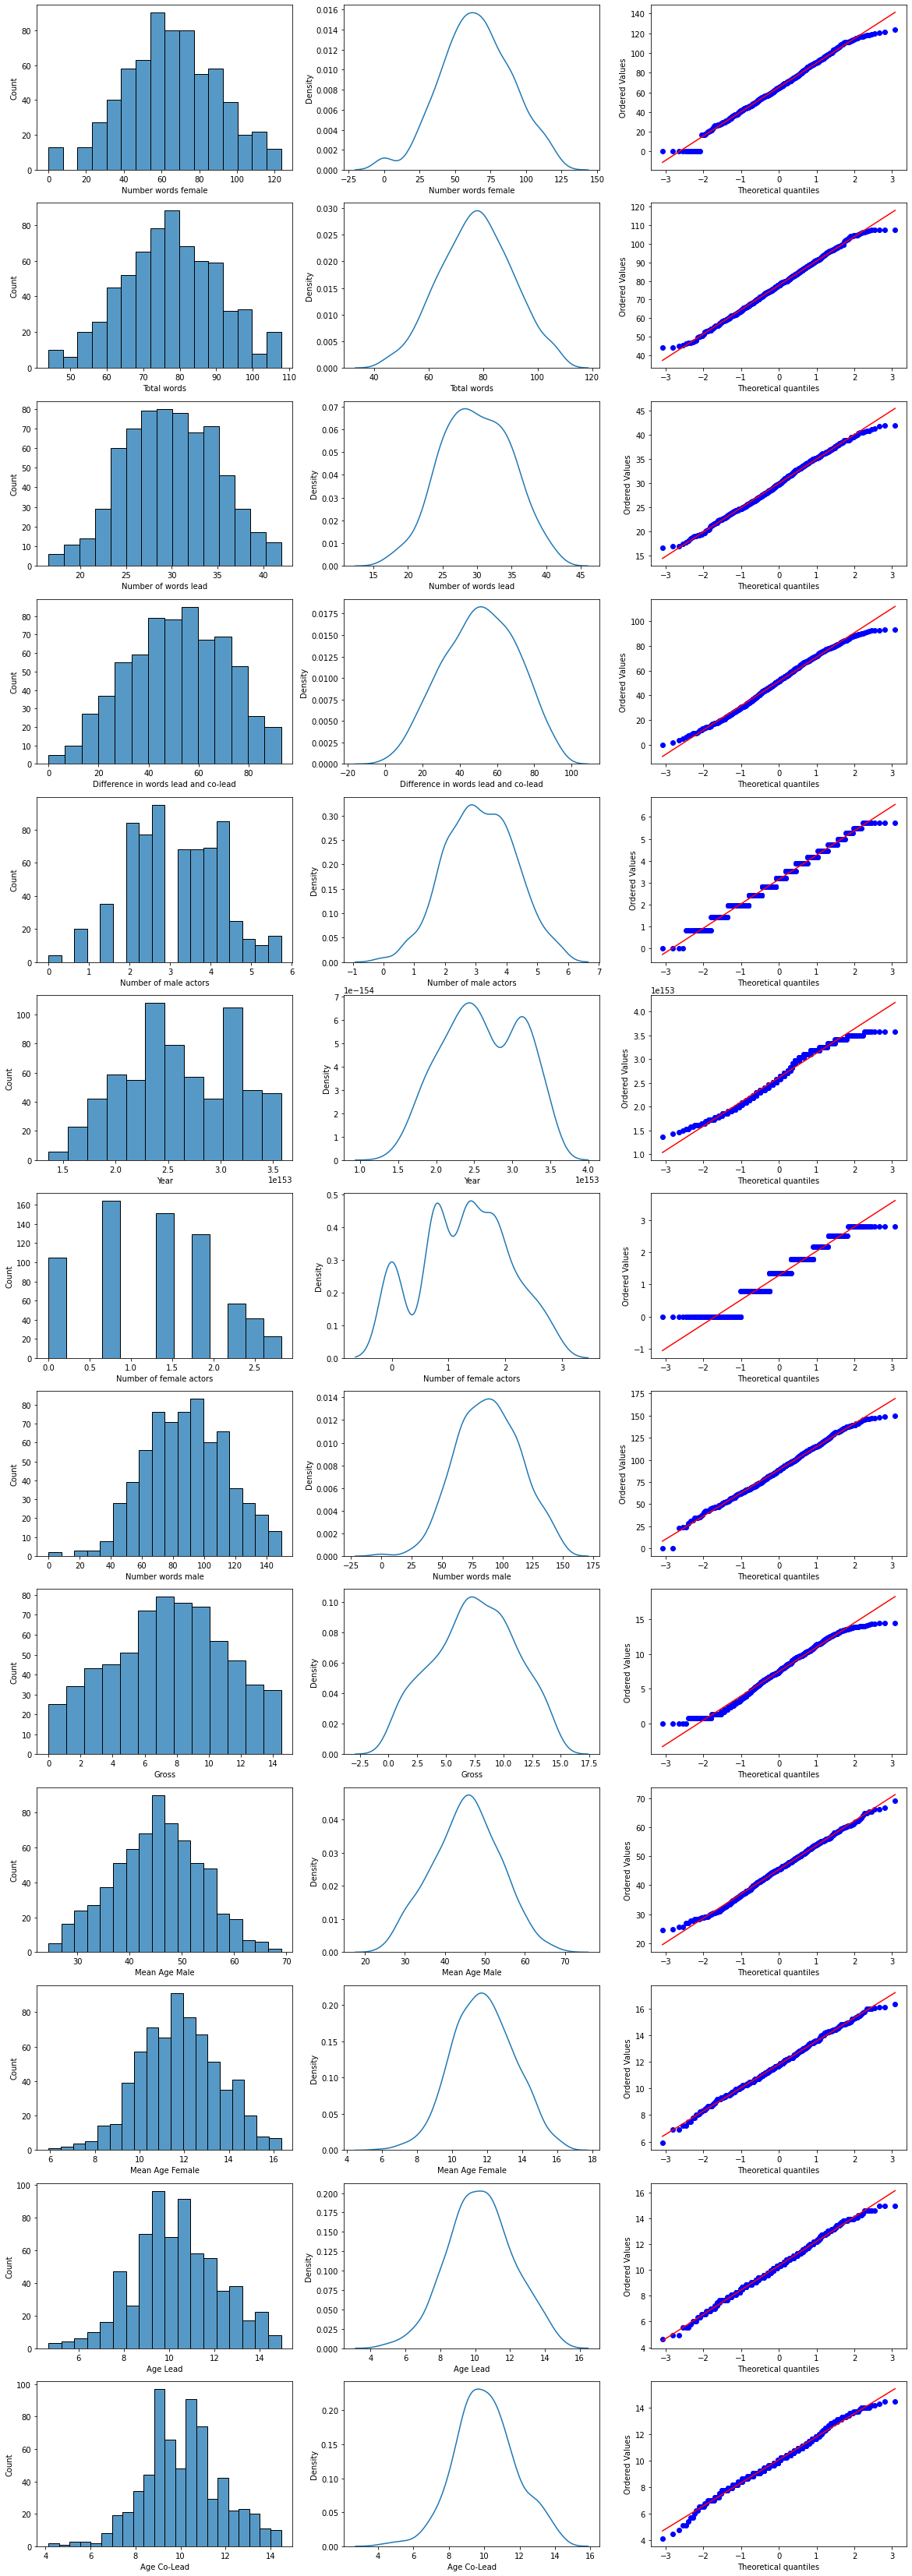

In [89]:
fig, axes = plt.subplots(13, 3, figsize=(20, 60))
i = 0

for col in x_new.columns:
    
    sns.histplot(ax = axes[i, 0], x=x_new[col])
    sns.kdeplot(ax = axes[i, 1], x=x_new[col])
    
    sc.stats.probplot(x= x_new[col],plot=axes[i, 2])
    axes[i, 2].set_title("")
    
    i += 1

In [90]:
model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9074626865671642

## Standarization

## !Warning! - Risk of data leak
Do not use scale unless you know what you are doing. A common mistake is to apply it to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set. In general, we recommend using StandardScaler within a Pipeline in order to prevent most risks of data leaking: pipe = make_pipeline(StandardScaler(), LogisticRegression()).

normalized_x, normalized_x_array = normalize(x)

model = dis_an.LinearDiscriminantAnalysis()

cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, normalized_x_array, y_array, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

In [91]:
#x_new, x_array_new = standarize(x_new)

In [92]:
model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9074626865671642

## Final Image after Pre Processing

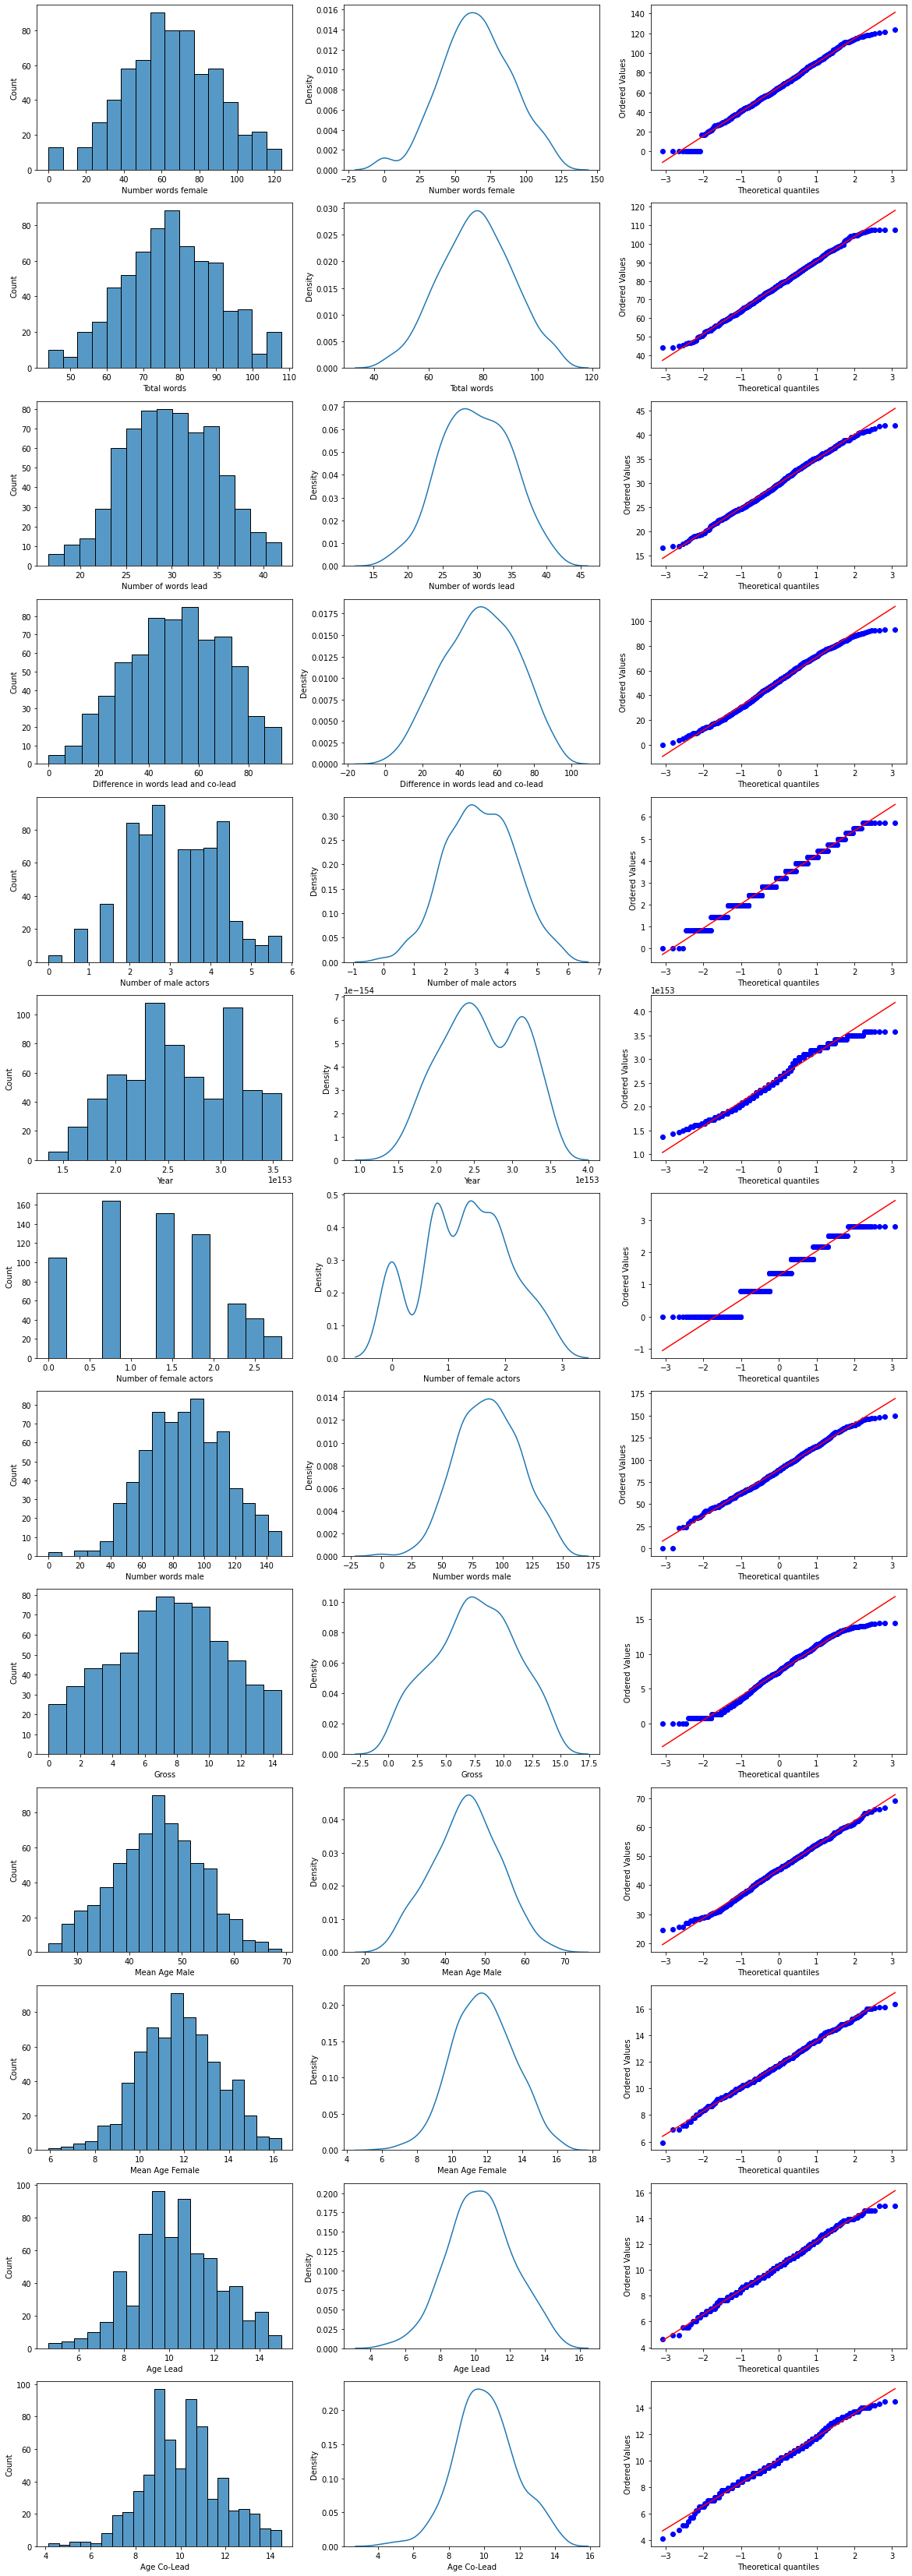

In [93]:
fig, axes = plt.subplots(13, 3, figsize=(20, 60))
i = 0

for col in x_new.columns:
    
    sns.histplot(ax = axes[i, 0], x=x_new[col])
    sns.kdeplot(ax = axes[i, 1], x=x_new[col])
    
    sc.stats.probplot(x= x_new[col],plot=axes[i, 2])
    axes[i, 2].set_title("")
    
    i += 1

In [103]:
model.fit(x_array_new, y_array_new)

pd.DataFrame(np.abs(model.coef_), columns=x_new.columns, index = ['Weight']).T.sort_values(by=['Weight'], ascending = False)

,Weight
Number of female actors,3.218596
Number of male actors,1.361949
Age Co-Lead,0.575117
Age Lead,0.474555
Number of words lead,0.320259
Total words,0.146281
Number words female,0.140521
Difference in words lead and co-lead,0.139137
Mean Age Female,0.124163
Mean Age Male,0.037627


In [104]:
#Remove year

x_new.drop(columns=['Year'], inplace = True)

x_array_new = np.array(x_new)

## Hyper-Parameter Tuning on LDA

In [105]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.stack.imgur.com/B9CCp.png")

In [106]:
model = dis_an.LinearDiscriminantAnalysis()

# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']

#n_jobs = Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. 
#-1 means using all processors.

search = mdl_sl.GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1,
                            verbose = 3)

results = search.fit(x_array_new, y_array_new)

print(results.best_score_)

print(results.best_params_)

Fitting 60 folds for each of 3 candidates, totalling 180 fits
0.9082073144573145
{'solver': 'lsqr'}


In [107]:
model = dis_an.LinearDiscriminantAnalysis()

# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

grid = dict()
grid['solver'] = ['lsqr', 'eigen']
grid['shrinkage'] = list(np.linspace(0,1,100))

#n_jobs = Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. 
#-1 means using all processors.

search = mdl_sl.GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1,
                            verbose = 3)

results = search.fit(x_array_new, y_array_new)

print(results.best_score_)

print(results.best_params_)

Fitting 60 folds for each of 200 candidates, totalling 12000 fits
0.9082073144573145
{'shrinkage': 0.0, 'solver': 'lsqr'}


Optimal shrinkage is 0 because the features have Gaussian distribution. So according to (https://scikit-learn.org/stable/modules/lda_qda.html):

The shrunk Ledoit and Wolf estimator of covariance may not always be the best choice. For example if the distribution of the data is normally distributed, the Oracle Shrinkage Approximating estimator sklearn.covariance.OAS yields a smaller Mean Squared Error than the one given by Ledoit and Wolf’s formula used with shrinkage=”auto”. In LDA, the data are assumed to be gaussian conditionally to the class. If these assumptions hold, using LDA with the OAS estimator of covariance will yield a better classification accuracy than if Ledoit and Wolf or the empirical covariance estimator is used.

The covariance estimator can be chosen using with the covariance_estimator parameter of the discriminant_analysis.LinearDiscriminantAnalysis class. A covariance estimator should have a fit method and a covariance_ attribute like all covariance estimators in the sklearn.covariance module.

In [108]:
oas = cov.OAS().fit(x_array_new)
oas_cov = oas.covariance_

model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', covariance_estimator = oas)

# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

# oas.precision_
# oas.shrinkage_

0.8274680930930931

We do not achieve better accuracy!

Let's check if by changing the tol, things get better...

tol: Absolute threshold for a singular value of X to be considered significant, used to estimate the rank of X. Dimensions whose singular values are non-significant are discarded. Only used if solver is ‘svd’.

In [109]:
model = dis_an.LinearDiscriminantAnalysis()

# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

grid = dict()
grid['solver'] = ['svd']
grid['tol'] = [0.0001,0.0002,0.0003]
grid['store_covariance'] = [True, False]

#n_jobs = Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. 
#-1 means using all processors.

search = mdl_sl.GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1,
                            verbose = 3)

results = search.fit(x_array_new, y_array_new)

print(results.best_score_)

print(results.best_params_)

Fitting 60 folds for each of 6 candidates, totalling 360 fits
0.908058504933505
{'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}


So best parameters for now:

0.9074579043329044

{'shrinkage': 0.0, 'solver': 'lsqr'}

## Feature Selection

https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [178]:
Image(url= "https://machinelearningmastery.com/wp-content/uploads/2019/11/Overview-of-Feature-Selection-Techniques3.png")


## Filter Methods

In [110]:
Image(url= "https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png")

We chose ANOVA

In [111]:
model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)

fs = feat_sel.SelectKBest(score_func=feat_sel.f_classif, k=12)

# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

pipeline = Pipeline(steps=[
    ('kbest',fs),
    ('lda', model)
])

scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9082073144573145

Only one feature removed:

In [112]:
fs.fit(x_array_new, y_array_new)

SelectKBest(k=12)

In [113]:
set(x_new.columns) - set(fs.get_feature_names_out(x_new.columns))

set()

## Wrapper Methods (RFE)

https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [114]:
def rfe(number_of_features):

    model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)

    selector = feat_sel.RFE(model, n_features_to_select=number_of_features, step=1, verbose = 3)

    cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

    pipeline = Pipeline(steps=[
        ('sel',selector),
        ('lda', model)
    ])

    scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

    return np.mean(scores)

In [115]:
for i in range(1,14):
    print("Number of features left: ", i, ". Accuracy= ", rfe(i))

Number of features left:  1 . Accuracy=  0.7598683504933504
Number of features left:  2 . Accuracy=  0.78565932003432
Number of features left:  3 . Accuracy=  0.782979407979408
Number of features left:  4 . Accuracy=  0.8067272629772629
Number of features left:  5 . Accuracy=  0.7973321535821537
Number of features left:  6 . Accuracy=  0.7965653153153152
Number of features left:  7 . Accuracy=  0.8556373337623338
Number of features left:  8 . Accuracy=  0.8965505684255685
Number of features left:  9 . Accuracy=  0.9082032925782926
Number of features left:  10 . Accuracy=  0.9082086550836551
Number of features left:  11 . Accuracy=  0.9082059738309739
Number of features left:  12 . Accuracy=  0.9082073144573145
Number of features left:  13 . Accuracy=  0.9082073144573145


In [116]:
model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)

selector = feat_sel.RFE(model, n_features_to_select=10, step=1, verbose = 3)

cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

pipeline = Pipeline(steps=[
        ('sel',selector),
        ('lda', model)
    ])

scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9082086550836551

In [117]:
selector.fit(x_array_new, y_array_new)

Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFE(estimator=LinearDiscriminantAnalysis(shrinkage=0, solver='lsqr'),
    n_features_to_select=10, verbose=3)

In [118]:
set(x_new.columns) - set(selector.get_feature_names_out(x_new.columns))

{'Gross', 'Number words male'}

Best choice 10 features! For now, we just removed the features with the less coef

## Trees (Random Forest)

rfc = ens.RandomForestClassifier()

grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

search = mdl_sl.GridSearchCV(rfc, grid, scoring='accuracy', cv=cv, n_jobs=-1,
                            verbose = 3)

results = search.fit(x_array_new, y_array_new)

results.best_param_

results.best_score

print(results.best_score_)

print(results.best_params_)

model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)

rfc = ens.RandomForestClassifier()

cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

grid = {
    'n_estimators': [10, 40, 80, 100, 120, 150],
    'criterion': ['gini', 'entropy'],
    'n_jobs': [-1]
}

search = mdl_sl.GridSearchCV(rfc, grid, scoring='accuracy', cv=cv, n_jobs=-1,
                            verbose = 3)

selector = feat_sel.SelectFromModel(search)

pipeline = Pipeline(steps=[
        ('sel',selector),
        ('lda', model)
    ])

scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

In [119]:
def rf(number_of_estimators):
    model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)

    rfc = ens.RandomForestClassifier(n_estimators = 100)

    selector = feat_sel.SelectFromModel(rfc)

    cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

    pipeline = Pipeline(steps=[
            ('sel',selector),
            ('lda', model)
        ])

    scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

    return np.mean(scores)

for i in range(100, 200, 10):
    print("Number of estimators: ", i, ". Accuracy= ", rf(i))

## SequentialFeatureSelector

In [120]:
model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)

sfs = feat_sel.SequentialFeatureSelector(model, n_features_to_select=4, n_jobs=-1)

cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

pipeline = Pipeline(steps=[
            ('sel',sfs),
            ('lda', model)
        ])

scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.826528314028314

In [121]:
sfs.fit(x_array_new, y_array_new)

SequentialFeatureSelector(estimator=LinearDiscriminantAnalysis(shrinkage=0,
                                                               solver='lsqr'),
                          n_features_to_select=4, n_jobs=-1)

In [122]:
set(x_new.columns) - set(sfs.get_feature_names_out(x_new.columns))

{'Age Co-Lead',
 'Age Lead',
 'Difference in words lead and co-lead',
 'Gross',
 'Mean Age Female',
 'Mean Age Male',
 'Number of words lead',
 'Total words'}

## BorutaPy

In [123]:
from boruta import BorutaPy

rfc = ens.RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

feat_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)

cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

pipeline = Pipeline(steps=[
            ('sel',feat_selector),
            ('lda', rfc)
        ])

scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

## Correlations

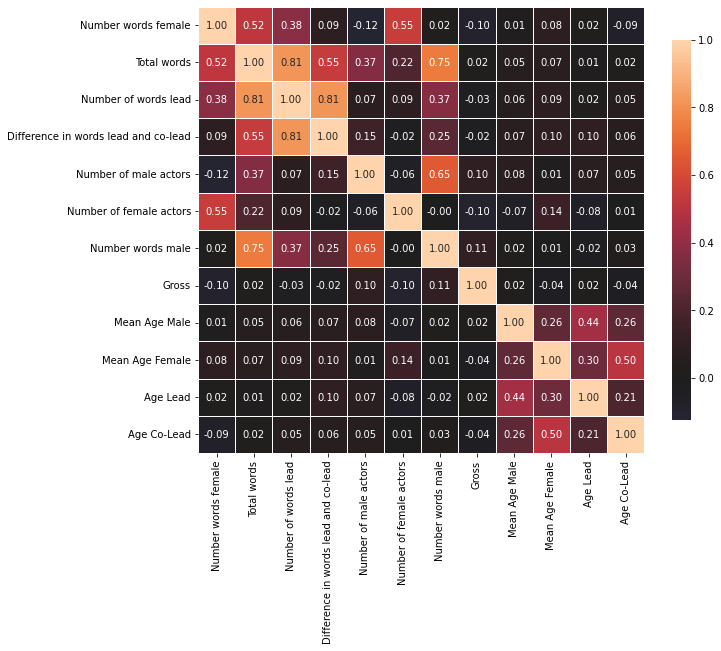

In [124]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(x_new.corr(), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

# Feature Engineering

In [125]:
x_new, x_array_new, y_new, y_array_new = zscore_outlier_removal(x, 3, y)

model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

x_new, x_array_new, y_new, y_array_new = iqrscore_outlier_removal(x, y)

model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

x_new, x_array_new, y_new, y_array_new = iqrscore_outlier_removal(x, y)
x_new, x_array_new, y_new, y_array_new = zscore_outlier_removal(x_new, 3, y_new)


model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

x_new, x_array_new, y_new, y_array_new = oneclasssvm_outlier_removal(x_array, x, y)

model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

x_new, x_array_new, y_new, y_array_new = oneclasssvm_outlier_removal(x_array, x, y)
x_new, x_array_new, y_new, y_array_new = iqrscore_outlier_removal(x_new, y_new)
x_new, x_array_new, y_new, y_array_new = zscore_outlier_removal(x_new, 3, y_new)

model = dis_an.LinearDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

115 records removed
300 records removed
300 records removed
39 records removed
288 records removed
32 records removed


0.8843283582089551

In [126]:
x_new['words per female actor']=x_new['Number words female']/x_new['Number of female actors']
x_new['words per male actor']=x_new['Number words male']/x_new['Number of male actors']
x_new['female words vs total words']=x_new['Number words female']/x_new['Total words']
x_new['male words vs total words']=x_new['Number words male']/x_new['Total words']
x_new['number of words co-lead']=x_new['Number of words lead']-x_new['Difference in words lead and co-lead']
x_new['female vs male ratio']=x_new['Number of female actors']/x_new['Number of male actors']

In [127]:
x_new['words per female actor'] += 1
x_new['words per male actor'] += 1
x_new['female words vs total words'] += 1
x_new['male words vs total words'] += 1

In [128]:
x_new['Number words female'] += 1
x_new['Number words male'] += 1
x_new['Gross'] += 1

In [129]:
x_new, x_array_new = transform_to_gaussian(x_new)

x_new, x_array_new = standarize(x_new)

model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9125321750321749

In [130]:
model.fit(x_array_new, y_array_new)

pd.DataFrame(np.abs(model.coef_), columns=x_new.columns, index = ['Weight']).T.sort_values(by=['Weight'], ascending = False)

,Weight
Number of words lead,6.178209
Total words,5.972356
Number words male,4.222049
female words vs total words,3.568166
Number words female,3.200761
number of words co-lead,2.687528
male words vs total words,2.353766
Number of female actors,2.247576
words per male actor,1.968424
Age Lead,0.987643


### By adding the new variables we go to 91.25%! Let's remove some variables!

In [131]:
x_new.drop(columns=['Gross'], inplace = True)

In [132]:
x_new.drop(columns=['Mean Age Male', 'Mean Age Female'], inplace = True)

In [142]:

x_array_new = np.array(x_new)

model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9150726619476619

## Including also the standarization pipeline

In [143]:
model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

ss = prp.StandardScaler()

pipeline = Pipeline(steps=[
    ('standardscaler', ss),
    ('lda',model)
])

scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9150726619476619

### By removing some variables we go to 91.52%

In [134]:
model.fit(x_array_new, y_array_new)

pd.DataFrame(np.abs(model.coef_), columns=x_new.columns, index = ['Weight']).T.sort_values(by=['Weight'], ascending = False)

,Weight
Number of words lead,5.679017
Total words,5.622857
Number words male,4.076320
female words vs total words,3.258180
Number words female,3.179225
number of words co-lead,2.664990
Number of female actors,2.157527
male words vs total words,1.978158
words per male actor,1.820742
Age Co-Lead,0.909316


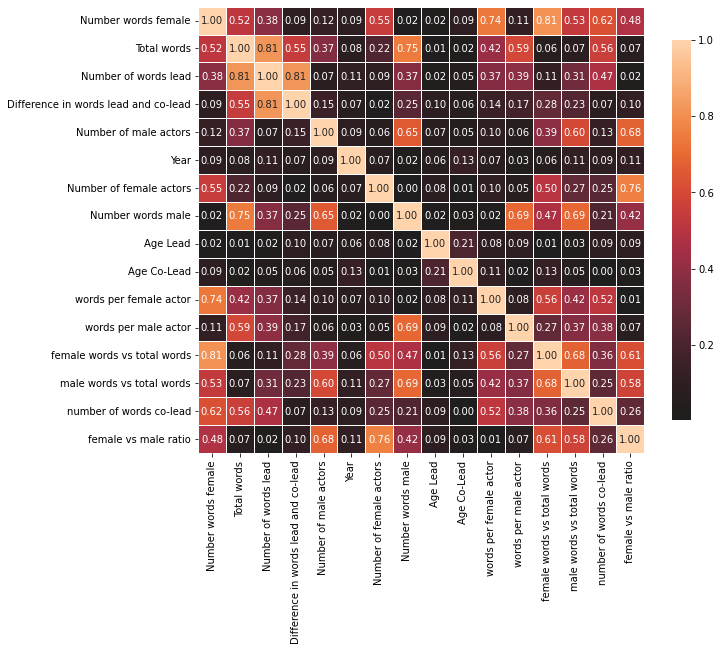

In [135]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.abs(x_new.corr()), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

# QDA

## Initial

In [136]:
model = dis_an.QuadraticDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array, y_array, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.8463136447190663

### After preprocessing - Without tuning hyperparameter

In [137]:
model = dis_an.QuadraticDiscriminantAnalysis()
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9283596096096096

### Tuning

In [138]:
model = dis_an.QuadraticDiscriminantAnalysis()

# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

grid = {'reg_param': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
       'tol': [0.0001,0.0002,0.0003]}

search = mdl_sl.GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1,
                            verbose = 3)

results = search.fit(x_array_new, y_array_new)

print(results.best_score_)

print(results.best_params_)

Fitting 60 folds for each of 21 candidates, totalling 1260 fits
0.950595238095238
{'reg_param': 0.1, 'tol': 0.0001}


### After tuning and standarization

In [144]:
model = dis_an.QuadraticDiscriminantAnalysis(reg_param=0.1, tol=0.0001)

cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

ss = prp.StandardScaler()

pipeline = Pipeline(steps=[
    ('standardscaler', ss),
    ('qda',model)
])

scores = mdl_sl.cross_val_score(pipeline, x_array_new, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9507453882453881

### Check if outliers are the same with LocalOutlierFactor

In [139]:
clf = nei.LocalOutlierFactor()

In [140]:
y_lof = clf.fit_predict(x)

In [141]:
pd.DataFrame(y_lof, columns=['is_inlier']).groupby(['is_inlier']).size()

is_inlier
-1      16
 1    1023
dtype: int64

This method is not eliminating as many outliers as we did

### Boxplots for accuarcy in different steps

### Collinearity

In [146]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [149]:
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]

In [150]:
vif_data

,feature,VIF
0,Number words female,inf
1,Total words,inf
2,Number of words lead,inf
3,Difference in words lead and co-lead,16.693791
4,Number of male actors,10.190608
5,Year,44.562311
6,Number of female actors,6.484289
7,Number words male,inf
8,Gross,1.614161
9,Mean Age Male,43.569994


In [151]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_new.columns
vif_data["VIF"] = [variance_inflation_factor(x_new.values, i) for i in range(len(x_new.columns))]

In [154]:
vif_data.sort_values(by='VIF')

,feature,VIF
5,Year,1.054239
8,Age Lead,1.109913
9,Age Co-Lead,1.114759
14,number of words co-lead,9.447355
11,words per male actor,15.652186
10,words per female actor,15.994512
3,Difference in words lead and co-lead,18.569141
4,Number of male actors,36.559112
6,Number of female actors,47.105080
13,male words vs total words,55.134214


Not good that we have big collinearity but we cannot do anything

#### Play with removing variables

In [156]:
x_new.columns

Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Age Lead',
       'Age Co-Lead', 'words per female actor', 'words per male actor',
       'female words vs total words', 'male words vs total words',
       'number of words co-lead', 'female vs male ratio'],
      dtype='object')

In [169]:
col_x = x_new.copy()

col_x.drop(columns=['Number of words lead', 'Total words', 'Number words male', 
                    'Number words female', 'female vs male ratio',
                   'female words vs total words', 'male words vs total words'], inplace = True)

col_x_array = np.array(col_x)

model = dis_an.LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)
# cross vailidation
cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

scores = mdl_sl.cross_val_score(model, col_x_array, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9117908086658085

In [170]:
col_x

,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Age Lead,Age Co-Lead,words per female actor,words per male actor,number of words co-lead
0,-0.278469,0.646692,-0.067135,0.662902,1.643703,0.090579,-0.375118,0.354401,-0.392898
1,0.665998,1.428086,0.051010,-0.627965,-0.385035,-1.206750,0.043432,-0.150770,-0.367024
2,0.940392,0.356229,-1.379272,0.662902,-0.108445,0.612929,-0.537684,-0.733097,-0.591936
3,-1.405592,-0.288731,-2.011319,0.087811,1.854864,-0.951902,-0.047246,-0.177998,-0.232934
4,0.581459,0.646692,-1.379272,-0.627965,0.897589,-0.240480,-1.148210,-0.619670,-1.868504
...,...,...,...,...,...,...,...,...,...
665,0.426803,0.646692,1.701685,0.087811,0.659013,-0.128502,0.526517,-0.315430,0.173411
666,-1.626654,-0.288731,-1.016565,-0.627965,-1.641590,0.090579,-0.581818,1.446433,0.729902
667,-1.278260,-2.081579,-0.182596,0.087811,-0.875305,-0.951902,-0.200189,-0.967347,-0.929554
668,-2.091286,0.356229,-0.618776,0.087811,-0.773984,-0.128502,-1.251885,-0.595552,-0.525204


#### What about QDA

In [171]:
model = dis_an.QuadraticDiscriminantAnalysis(reg_param=0.1, tol=0.0001)

cv = mdl_sl.RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=1)

ss = prp.StandardScaler()

pipeline = Pipeline(steps=[
    ('standardscaler', ss),
    ('qda',model)
])

scores = mdl_sl.cross_val_score(pipeline, col_x_array, y_array_new, scoring='accuracy', cv=cv, n_jobs=-1)

np.mean(scores)

0.9401571214071214

## Plotting

# Useful Links

We have to use ensemble to check the different models

https://github.com/javiabellan/machine-learning#-dimensionality-reduction-

https://www.kaggle.com/anirudh2312/interpretation-and-tuning-of-hyperparameters